In [1]:
#import packages
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import urllib
import sys
from matplotlib import pyplot as plt
import datetime as dt
import geopandas as gpd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from datetime import datetime
#!pip install clusim
from clusim.clustering import Clustering, remap2match
import clusim.sim as sim
from math import pi

%matplotlib inline

In [2]:
#!pip install clusim

# 1. Data Preprocessing

For this analysis, we'll be looking at the period December 1st to May 23rd across three years (2017-18, 2018-19 and 2019-20) to see how the volume and type of 311 complaints changed during the first lockdown period (March 15th to May 23rd 2020) in New York City.

In [4]:
#load data, City of NYC 311 complaints
#Source: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9/data
#filter for created date is between 12/1 and before 5/23 of the following years: 2017-18, 2018-19, 2019-20
complaints_1718 = pd.read_csv("311_Service_Requests_2017_2018.csv")
complaints_1819 = pd.read_csv("311_Service_Requests_2018_2019.csv")
complaints_1920 = pd.read_csv("311_Service_Requests_2019_2020.csv")

/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8,17,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
complaints_1718.head(2)

Unique Key            Created Date             Closed Date Agency  \
0    37821703  12/01/2017 12:00:00 AM  12/01/2017 12:00:00 AM  DOHMH   
1    37817381  12/01/2017 12:00:00 AM  12/05/2017 12:00:00 AM  DOHMH   

                               Agency Name                  Complaint Type  \
0  Department of Health and Mental Hygiene  Unsanitary Animal Pvt Property   
1  Department of Health and Mental Hygiene                          Rodent   

                     Descriptor                 Location Type Incident Zip  \
0                           Dog  3+ Family Apartment Building      10009.0   
1  Condition Attracting Rodents       3+ Family Apt. Building      11004.0   

   Incident Address  ... Vehicle Type Taxi Company Borough  \
0      277 AVENUE C  ...          NaN                  NaN   
1  74-15 255 STREET  ...          NaN                  NaN   

  Taxi Pick Up Location Bridge Highway Name Bridge Highway Direction  \
0                   NaN                 NaN                      NaN   
1                   NaN                 NaN                      NaN   

  Road Ramp Bridge Highway Segment   Latitude  Longitude  \
0       NaN                    NaN  40.730008 -73.974668   
1       NaN                    NaN  40.747718 -73.716946   

                                  Location  
0  (40.73000753861665, -73.97466769783162)  
1  (40.74771750476338, -73.71694648641322)  

[2 rows x 41 columns]

In [6]:
#combine all noise-related complaints
complaints_1718.loc[complaints_1718['Complaint Type'].str.contains('Noise'), 'Complaint Type'] = 'Noise'
complaints_1819.loc[complaints_1819['Complaint Type'].str.contains('Noise'), 'Complaint Type'] = 'Noise'
complaints_1920.loc[complaints_1920['Complaint Type'].str.contains('Noise'), 'Complaint Type'] = 'Noise'

In [7]:
#combine all tree-related complaints
complaints_1718.loc[complaints_1718['Complaint Type'].str.contains('Tree'), 'Complaint Type'] = 'Tree-related'
complaints_1819.loc[complaints_1819['Complaint Type'].str.contains('Tree'), 'Complaint Type'] = 'Tree-related'
complaints_1920.loc[complaints_1920['Complaint Type'].str.contains('Tree'), 'Complaint Type'] = 'Tree-related'

In [8]:
#Check the total number of complaints for each time period as well the number of unique complaint types
print('The total number of 311 complaints from December 1st 2017 to May 23rd 2018 is {0} with {1} unique complaint types.'.format((len(complaints_1718)),len(complaints_1718['Complaint Type'].value_counts())))
print('The total number of 311 complaints from December 1st 2018 to May 23rd 2019 is {0} with {1} unique complaint types.'.format((len(complaints_1819)),len(complaints_1819['Complaint Type'].value_counts())))
print('The total number of 311 complaints from December 1st 2019 to May 23rd 2020 is {0} with {1} unique complaint types.'.format((len(complaints_1920)),len(complaints_1920['Complaint Type'].value_counts())))

The total number of 311 complaints from December 1st 2017 to May 23rd 2018 is 1263597 with 212 unique complaint types.
The total number of 311 complaints from December 1st 2018 to May 23rd 2019 is 1276470 with 217 unique complaint types.
The total number of 311 complaints from December 1st 2019 to May 23rd 2020 is 925367 with 159 unique complaint types.


Are the same complaint types the most popular across all three years? Since there are so many different complaint types, look at the top 30 types for each year to see how they compare.

In [9]:
# Create a frequency table in order to plot each type of complaint
complaint_type1718 = complaints_1718['Complaint Type'].groupby(complaints_1718['Complaint Type']).count().sort_values(ascending=False).reset_index(name='count')
complaint_type1718 = complaint_type1718.set_index('Complaint Type')
complaint_type1819 = complaints_1819['Complaint Type'].groupby(complaints_1819['Complaint Type']).count().sort_values(ascending=False).reset_index(name='count')
complaint_type1819 = complaint_type1819.set_index('Complaint Type')
complaint_type1920 = complaints_1920['Complaint Type'].groupby(complaints_1920['Complaint Type']).count().sort_values(ascending=False).reset_index(name='count')
complaint_type1920 = complaint_type1920.set_index('Complaint Type')

# 2. Exploratory Analysis

## 2.1. Complaint volume per type over time

Text(0, 0.5, 'Total 311 Complaints')

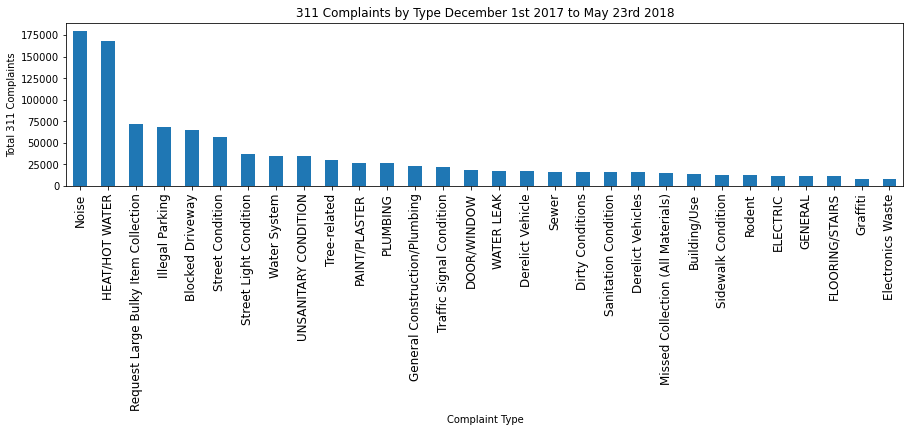

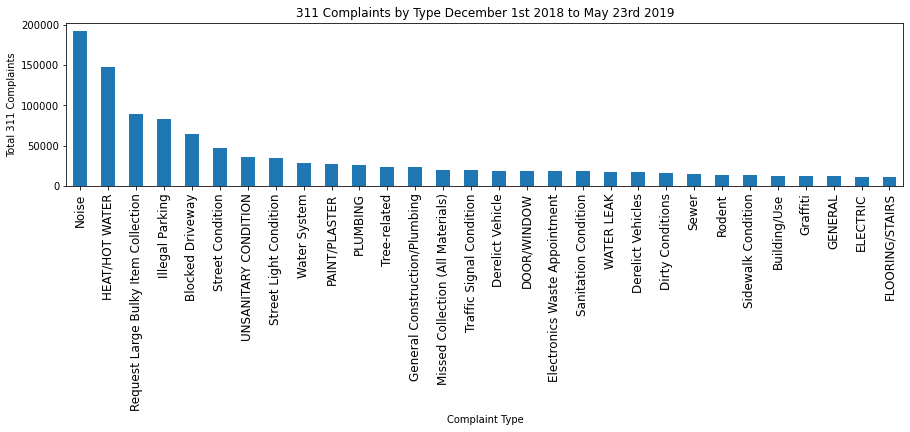

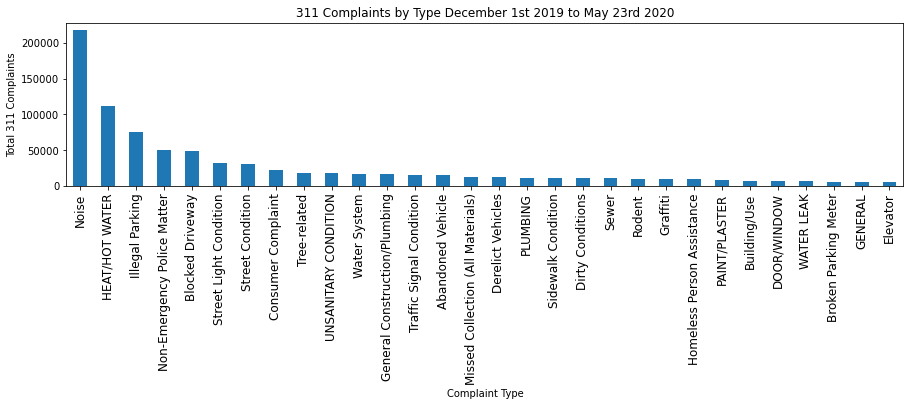

In [10]:
figsize = (15,3)
fontsize = 12
complaint_type1718[0:30].plot.bar(figsize=figsize,legend=None)
plt.title('311 Complaints by Type December 1st 2017 to May 23rd 2018', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel('Total 311 Complaints')
#plt.savefig("img/Volume_1718.jpg", dpi=150)

complaint_type1819[0:30].plot.bar(figsize=figsize,legend=None)
plt.title('311 Complaints by Type December 1st 2018 to May 23rd 2019', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel('Total 311 Complaints')
#plt.savefig("img/Volume_1819.jpg", dpi=150)

complaint_type1920[0:30].plot.bar(figsize=figsize,legend=None)
plt.title('311 Complaints by Type December 1st 2019 to May 23rd 2020', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel('Total 311 Complaints')
#plt.savefig("img/Volume_1920.jpg", dpi=150)

## 2.2. Unique top 30 complaints

In [11]:
# top complaints for each period

In [12]:
cols = ['1718', '1819', '1920']
data = {'1718':complaint_type1718[0:39].index.tolist(),
        '1819':complaint_type1819[0:39].index.tolist(),
        '1920':complaint_type1920[0:39].index.tolist()}
top30df = pd.DataFrame(data)

In [13]:
top30df

1718                                 1819  \
0                                 Noise                                Noise   
1                        HEAT/HOT WATER                       HEAT/HOT WATER   
2   Request Large Bulky Item Collection  Request Large Bulky Item Collection   
3                       Illegal Parking                      Illegal Parking   
4                      Blocked Driveway                     Blocked Driveway   
5                      Street Condition                     Street Condition   
6                Street Light Condition                 UNSANITARY CONDITION   
7                          Water System               Street Light Condition   
8                  UNSANITARY CONDITION                         Water System   
9                          Tree-related                        PAINT/PLASTER   
10                        PAINT/PLASTER                             PLUMBING   
11                             PLUMBING                         Tree-related   
12        General Construction/Plumbing        General Construction/Plumbing   
13             Traffic Signal Condition    Missed Collection (All Materials)   
14                          DOOR/WINDOW             Traffic Signal Condition   
15                           WATER LEAK                     Derelict Vehicle   
16                     Derelict Vehicle                          DOOR/WINDOW   
17                                Sewer        Electronics Waste Appointment   
18                     Dirty Conditions                 Sanitation Condition   
19                 Sanitation Condition                           WATER LEAK   
20                    Derelict Vehicles                    Derelict Vehicles   
21    Missed Collection (All Materials)                     Dirty Conditions   
22                         Building/Use                                Sewer   
23                   Sidewalk Condition                               Rodent   
24                               Rodent                   Sidewalk Condition   
25                             ELECTRIC                         Building/Use   
26                              GENERAL                             Graffiti   
27                      FLOORING/STAIRS                              GENERAL   
28                             Graffiti                             ELECTRIC   
29                    Electronics Waste                      FLOORING/STAIRS   
30       DOF Property - Reduction Issue           For Hire Vehicle Complaint   
31                   Consumer Complaint                             Elevator   
32                       Taxi Complaint      Construction Safety Enforcement   
33           Homeless Person Assistance                 Broken Parking Meter   
34                             Elevator                   Consumer Complaint   
35             Benefit Card Replacement       DOF Property - Reduction Issue   
36                            APPLIANCE                            APPLIANCE   
37         DOF Property - Payment Issue                       Taxi Complaint   
38           For Hire Vehicle Complaint           Homeless Person Assistance   

                                   1920  
0                                 Noise  
1                        HEAT/HOT WATER  
2                       Illegal Parking  
3           Non-Emergency Police Matter  
4                      Blocked Driveway  
5                Street Light Condition  
6                      Street Condition  
7                    Consumer Complaint  
8                          Tree-related  
9                  UNSANITARY CONDITION  
10                         Water System  
11        General Construction/Plumbing  
12             Traffic Signal Condition  
13                    Abandoned Vehicle  
14    Missed Collection (All Materials)  
15                    Derelict Vehicles  
16                             PLUMBING  
17                   Sidewalk Condition  
18                     Dirty Conditi

The top complaint type of 2017-18 and 2018-19 is 'heat/hot water' but in 2019-20, the top complaint is 'noise-residential'

In [14]:
# unique top 30 df for the 3 periods

In [15]:
from collections import Counter

a = top30df['1718'].tolist()
b = top30df['1819'].tolist()
c= top30df['1920'].tolist()
mylist = a+b+c
Counter(mylist)

top30_complaint_set = [k for k,v in Counter(mylist).items() if float(v) == 3]
top30_complaint_set

['Noise',
 'HEAT/HOT WATER',
 'Illegal Parking',
 'Blocked Driveway',
 'Street Condition',
 'Street Light Condition',
 'Water System',
 'UNSANITARY CONDITION',
 'Tree-related',
 'PAINT/PLASTER',
 'PLUMBING',
 'General Construction/Plumbing',
 'Traffic Signal Condition',
 'DOOR/WINDOW',
 'WATER LEAK',
 'Sewer',
 'Dirty Conditions',
 'Derelict Vehicles',
 'Missed Collection (All Materials)',
 'Building/Use',
 'Sidewalk Condition',
 'Rodent',
 'ELECTRIC',
 'GENERAL',
 'Graffiti',
 'Consumer Complaint',
 'Homeless Person Assistance',
 'Elevator',
 'APPLIANCE',
 'For Hire Vehicle Complaint']

In [16]:
len(top30_complaint_set)

30

In [17]:
# create empty df
cols = ['1718_pos','1819_pos','1920_pos']
rankingdf = pd.DataFrame(columns=cols, index=top30_complaint_set)
rankingdf.head()

# populate df
position_1718 = []
position_1819 = []
position_1920 = []

def position(year, positionlist):
    for i in top30_complaint_set:
        if i in top30df[year].tolist():
            position =  top30df.loc[top30df[year]==i].index[0]
        else:
            position = 0
        positionlist.append(position)
        
position('1718', position_1718)
position('1819', position_1819)
position('1920', position_1920)

rankingdf['1718_pos'] = position_1718
rankingdf['1819_pos'] = position_1819
rankingdf['1920_pos'] = position_1920

rankingdf = rankingdf.apply(lambda x: x+1, axis=1)
rankingdf.index = rankingdf.index.str.lower()
rankingdf.sort_values(['1920_pos'], ascending=True)

1718_pos  1819_pos  1920_pos
noise                                     1         1         1
heat/hot water                            2         2         2
illegal parking                           4         4         3
blocked driveway                          5         5         5
street light condition                    7         8         6
street condition                          6         6         7
consumer complaint                       32        35         8
tree-related                             10        12         9
unsanitary condition                      9         7        10
water system                              8         9        11
general construction/plumbing            13        13        12
traffic signal condition                 14        15        13
missed collection (all materials)        22        14        15
derelict vehicles                        21        21        16
plumbing                                 12        11        17
sidewalk condition                       24        25        18
dirty conditions                         19        22        19
sewer                                    18        23        20
rodent                                   25        24        21
graffiti                                 29        27        22
homeless person assistance               34        39        23
paint/plaster                            11        10        24
building/use                             23        26        25
door/window                              15        17        26
water leak                               16        20        27
general                                  27        28        29
elevator                                 35        32        30
for hire vehicle complaint               39        31        31
electric                                 26        29        32
appliance                                37        37        35

In [18]:
# style it for better understanding (option a)

In [19]:
rankingdf.style.bar(subset=['1718_pos', '1819_pos', '1920_pos'], color='khaki', vmin=30, vmax=1)

In [20]:
rankingdf.style.bar(subset=['1718_pos', '1819_pos', '1920_pos'], color='powderblue', vmin=30, vmax=1)

In [21]:
# style it for better understanding (option b)

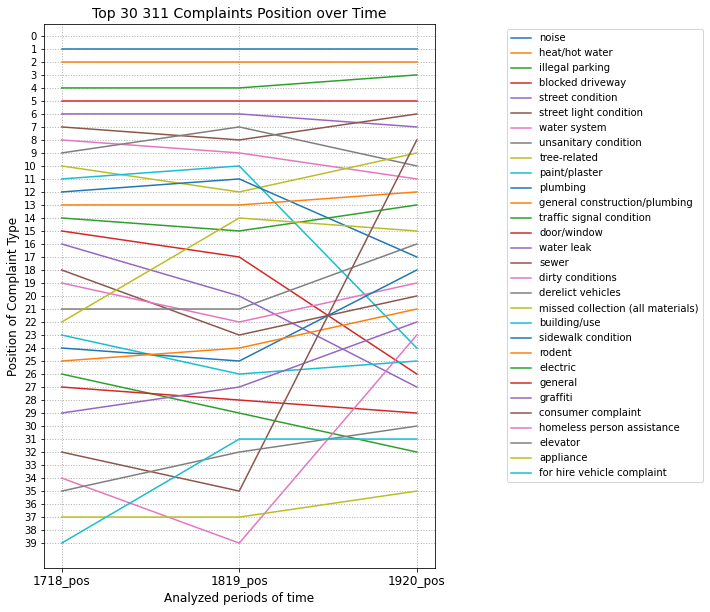

In [22]:
rT = rankingdf.transpose()

plt.figure(figsize = (7,10))
fontsize_1 = 12
fontsize_2 = 14
for i in range(len(rT.columns)):
    plt.plot(rT.iloc[:,i], label=rT.columns[i])

plt.gca().invert_yaxis() # invert y so that "ranking" goes from top0 to top29
plt.xticks(fontsize=fontsize_1)
plt.yticks(range(0,40))

plt.xlabel('Analyzed periods of time', fontsize=fontsize_1)
plt.ylabel('Position of Complaint Type', fontsize=fontsize_1)
plt.title('Top 30 311 Complaints Position over Time', fontsize=fontsize_2)
plt.legend(bbox_to_anchor=(1.7, 1), loc='upper right')
plt.grid(linestyle='dotted', linewidth=1)
plt.show()

## 2.3 Daily, weekly and monthly activity per complaint type

In [23]:
#add day, month and week variables for grouping
complaints_1718['Created Date'] = pd.to_datetime(complaints_1718['Created Date'])
complaints_1718['Created Date']=pd.DatetimeIndex(complaints_1718['Created Date']).date
complaints_1718['Month']=pd.DatetimeIndex(complaints_1718['Created Date']).month
complaints_1718['Week']=pd.DatetimeIndex(complaints_1718['Created Date']).week
complaints_1819['Created Date'] = pd.to_datetime(complaints_1819['Created Date'])
complaints_1819['Created Date']=pd.DatetimeIndex(complaints_1819['Created Date']).date
complaints_1819['Month']=pd.DatetimeIndex(complaints_1819['Created Date']).month
complaints_1819['Week']=pd.DatetimeIndex(complaints_1819['Created Date']).week
complaints_1920['Created Date'] = pd.to_datetime(complaints_1920['Created Date'])
complaints_1920['Created Date']=pd.DatetimeIndex(complaints_1920['Created Date']).date
complaints_1920['Month']=pd.DatetimeIndex(complaints_1920['Created Date']).month
complaints_1920['Week']=pd.DatetimeIndex(complaints_1920['Created Date']).week

<ipython-input-23-ba37e2cc547c>:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  complaints_1718['Week']=pd.DatetimeIndex(complaints_1718['Created Date']).week
<ipython-input-23-ba37e2cc547c>:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  complaints_1819['Week']=pd.DatetimeIndex(complaints_1819['Created Date']).week
<ipython-input-23-ba37e2cc547c>:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return a

In [24]:
#group complaints by type and month. Note: we will only look at complaints in top30_complaint_set

# top 30
top30_1718 = complaints_1718.loc[(complaints_1718['Complaint Type'].isin(top30_complaint_set))]
top30_1819 = complaints_1819.loc[(complaints_1819['Complaint Type'].isin(top30_complaint_set))]
top30_1920 = complaints_1920.loc[(complaints_1920['Complaint Type'].isin(top30_complaint_set))]

# top 15
top15_1718 = complaints_1718['Complaint Type'].value_counts()[0:15].index.tolist()
top15_1718 = complaints_1718.loc[(complaints_1718['Complaint Type'].isin(top15_1718))]
top15_1819 = complaints_1819['Complaint Type'].value_counts()[0:15].index.tolist()
top15_1819 = complaints_1819.loc[(complaints_1819['Complaint Type'].isin(top15_1819))]
top15_1920 = complaints_1920['Complaint Type'].value_counts()[0:15].index.tolist()
top15_1920 = complaints_1920.loc[(complaints_1920['Complaint Type'].isin(top15_1920))]

In [25]:
# monthly complaints by type, 2017-18
def monthly_groupby(filename):
    return filename.groupby(['Complaint Type', 'Month'])['Unique Key'].count().unstack(fill_value=0).rename_axis(None, axis=1).transpose().reset_index().rename(columns = {'index':'Month'})
    
def cleaning_steps(filename, monthsdict):
    filename["Month"] = filename["Month"].replace(monthsdict)
    filename["Month"]  = pd.to_datetime(filename["Month"])
    filename = filename.sort_values(by='Month')
    filename["Month"] = filename["Month"].dt.strftime('%m-%Y')
    return filename.set_index('Month') 

def plot_complaints_by_month(filename, years):
    plt.figure(figsize=(12,8))
    for i in filename.columns:
        plt.plot(filename.index, filename[i], label = i)
    plt.title('Number of complaint types by month, {}'.format(years), fontsize=14)
    plt.xticks(filename.index)
    plt.ylabel('Total 311 Complaints')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


In [26]:
months_1718 = {1: "01-2018", 2: "02-2018",3:'03-2018',4:'04-2018',5:'05-2018',12:'12-2017'}
months_1819 = {1: "01-2019", 2: "02-2019",3:'03-2019',4:'04-2019',5:'05-2019',12:'12-2018'}
months_1920 = {1: "01-2020", 2: "02-2020",3:'03-2020',4:'04-2020',5:'05-2020',12:'12-2019'}

# top30
complaints_1718_month = monthly_groupby(top30_1718)
complaints_1819_month = monthly_groupby(top30_1819)
complaints_1920_month = monthly_groupby(top30_1920)

complaints_1718_month = cleaning_steps(complaints_1718_month, months_1718)
complaints_1819_month = cleaning_steps(complaints_1819_month, months_1819)
complaints_1920_month = cleaning_steps(complaints_1920_month, months_1920)

In [27]:
# group complaints by week and month. Note: we will only look at complaints in top30_complaint_set

def weekly_groupby(filename):
    return filename.groupby(['Complaint Type', 'Week'])['Unique Key'].count().unstack(fill_value=0).rename_axis(None, axis=1).transpose().reset_index().rename(columns = {'index':'Week'})
    
def cleaning_steps_weeks(filename, period1, period2):
    dict_week = {}
    for value in filename.Week:
        if (value >=1)& (value <22):
            dict_week[value] = period1+str(value).zfill(2)
        elif (value>22):
            dict_week[value] = period2+str(value).zfill(2)
    filename["Week"] = filename["Week"].replace(dict_week)
    return filename.sort_values(by='Week').set_index('Week')

def plot_complaints_by_week(filename, years):
    plt.figure(figsize=(12,8))
    for i in filename.columns:
        plt.plot(filename.index, filename[i], label = i)
    plt.title('Number of complaint types by week, {}'.format(years), fontsize=14)
    plt.xticks(filename.index,rotation = 90)
    plt.ylabel('Total 311 Complaints')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [28]:
# top30
complaints_1718_week = weekly_groupby(top30_1718)
complaints_1819_week = weekly_groupby(top30_1819)
complaints_1920_week = weekly_groupby(top30_1920)

complaints_1718_week = cleaning_steps_weeks(complaints_1718_week, '2018_week_', '2017_week_')
complaints_1819_week = cleaning_steps_weeks(complaints_1819_week, '2019_week_', '2018_week_')
complaints_1920_week = cleaning_steps_weeks(complaints_1920_week, '2020_week_', '2019_week_')

In [29]:
#group by day to get daily counts for
complaints_1718_daily = complaints_1718['Created Date'].groupby(complaints_1718['Created Date']).count().reset_index(name='count')
complaints_1819_daily = complaints_1819['Created Date'].groupby(complaints_1819['Created Date']).count().reset_index(name='count')
complaints_1920_daily = complaints_1920['Created Date'].groupby(complaints_1920['Created Date']).count().reset_index(name='count')

In [30]:
# VISUALIZATIONS

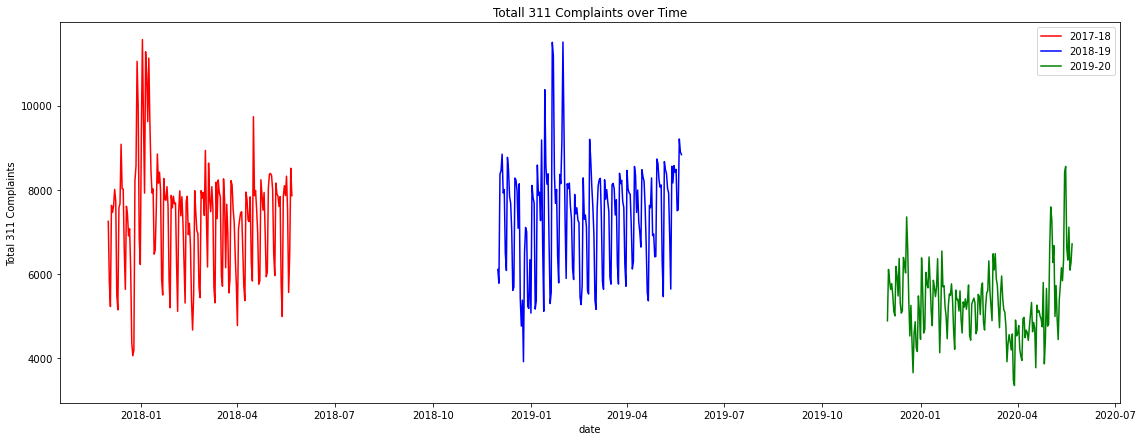

In [32]:
# visualize how volume of complaints has changed (visualization a)
plt.figure(figsize = (19,7))
plt.plot(complaints_1718_daily.iloc[:-1,:]['Created Date'], complaints_1718_daily.iloc[:-1,:]['count'], color='red', label='2017-18')
plt.plot(complaints_1819_daily.iloc[:-1,:]['Created Date'], complaints_1819_daily.iloc[:-1,:]['count'], color='blue', label= '2018-19')
plt.plot(complaints_1920_daily.iloc[:-1,:]['Created Date'], complaints_1920_daily.iloc[:-1,:]['count'], color='green', label= '2019-20')
plt.xlabel('date')
plt.ylabel('Total 311 Complaints')
plt.title('Totall 311 Complaints over Time')
plt.legend()
#plt.savefig("img/Complaints_over_time.png", dpi=150)

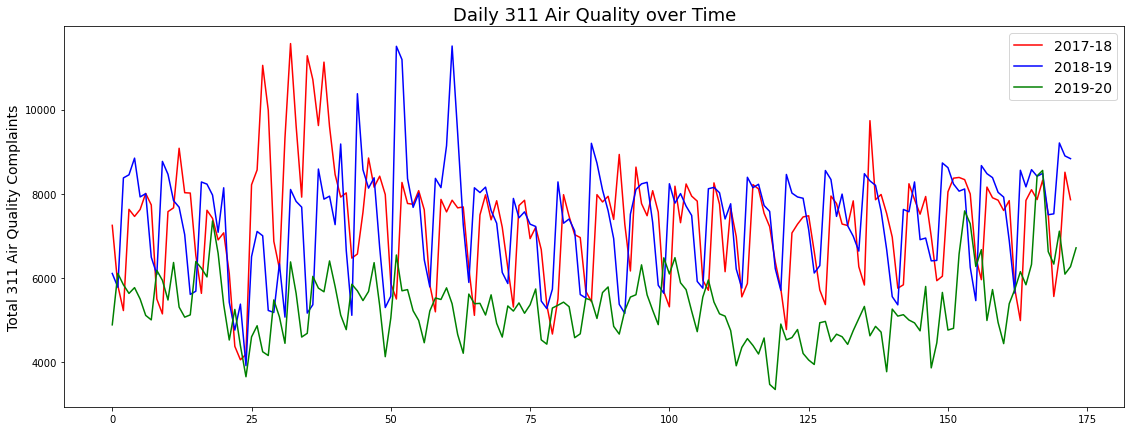

In [33]:
# visualize how volume of complaints has changed (visualization b)
plt.figure(figsize = (19,7))

plt.plot(complaints_1718_daily.iloc[:-1,:].index, complaints_1718_daily.iloc[:-1,:]['count'], color='red', label='2017-18')
plt.plot(complaints_1819_daily.iloc[:-1,:].index, complaints_1819_daily.iloc[:-1,:]['count'], color='blue', label= '2018-19')
plt.plot(complaints_1920_daily.iloc[:-1,:].index, complaints_1920_daily.iloc[:-1,:]['count'], color='green', label= '2019-20')

plt.ylabel('Total 311 Air Quality Complaints', fontsize=14)
plt.title('Daily 311 Air Quality over Time', fontsize=18)
plt.legend(fontsize=14)

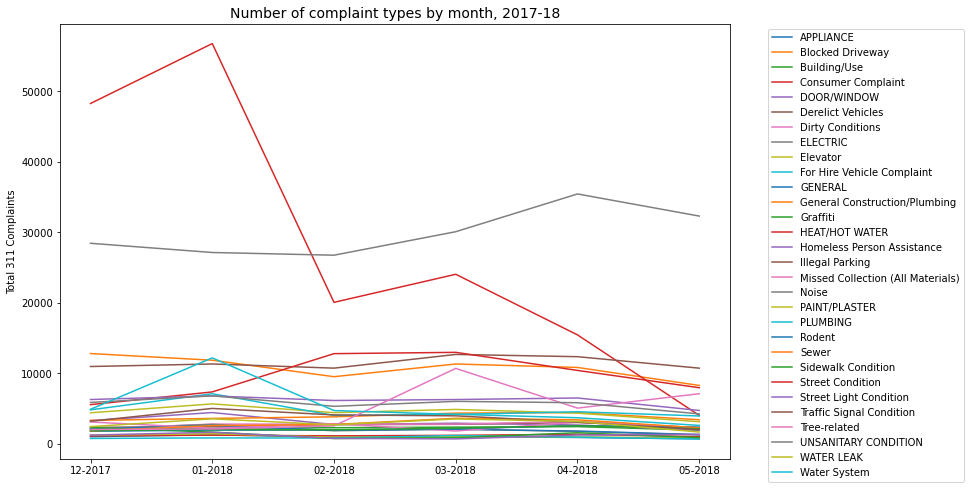

In [34]:
plot_complaints_by_month(complaints_1718_month, '2017-18')

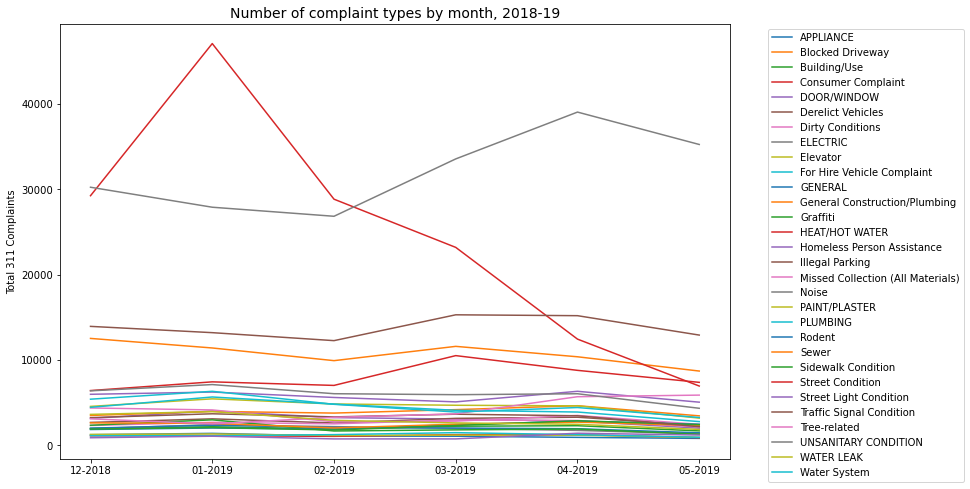

In [35]:
plot_complaints_by_month(complaints_1819_month, '2018-19')

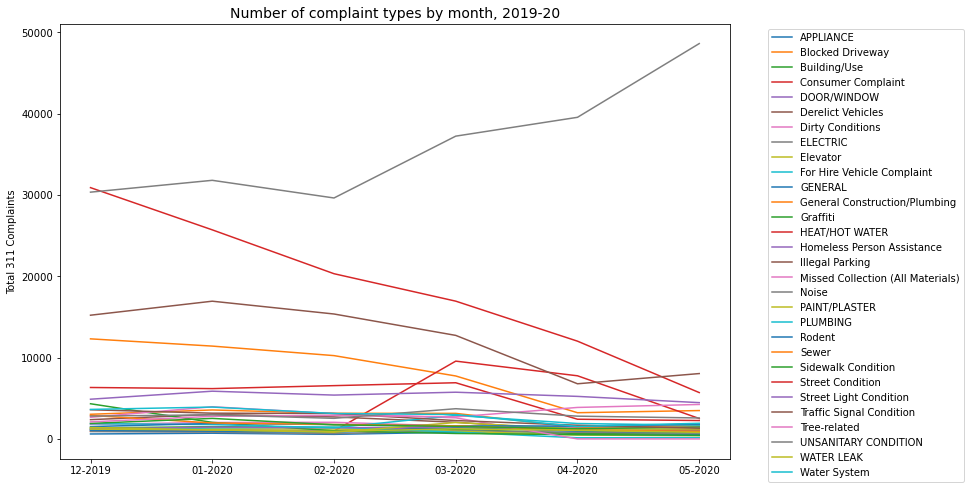

In [36]:
plot_complaints_by_month(complaints_1920_month, '2019-20')

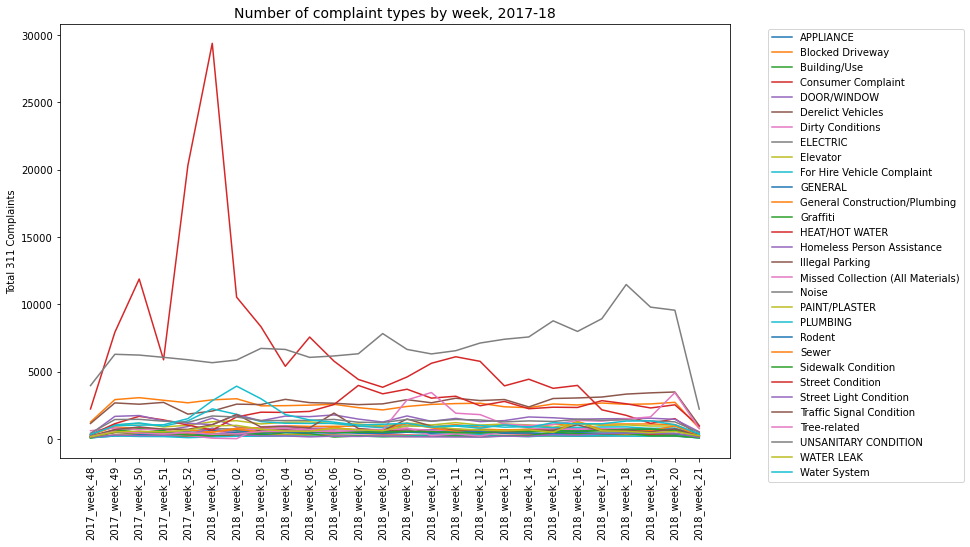

In [37]:
plot_complaints_by_week(complaints_1718_week, '2017-18')

Now that we have seen how the volume of complaints and their type vary across time, let's see how they change across space.

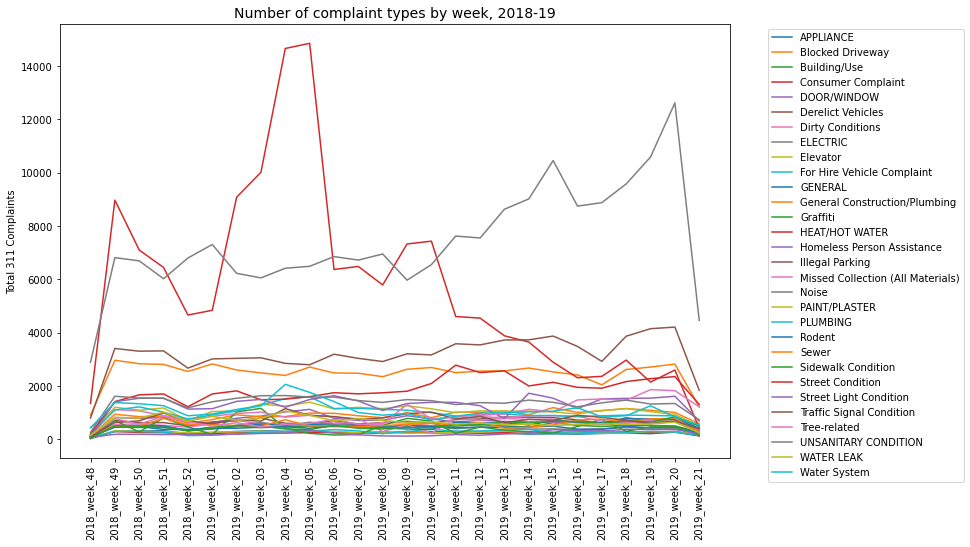

In [38]:
plot_complaints_by_week(complaints_1819_week, '2018-19')

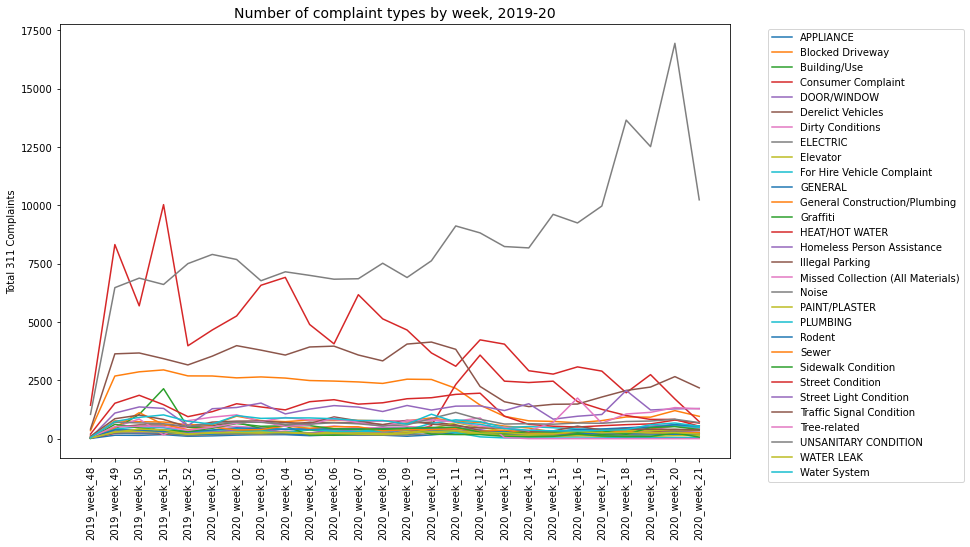

In [39]:
plot_complaints_by_week(complaints_1920_week, '2019-20')

## 2.4 Geospatial analysis

In [40]:
# load NYC shape file for spatial join

# different paths for all 3 team members
#path = 'C:/Users/aalsi/Documents/GitHub/CUSP2021MLC-Team'
path = '/Users/dinawagdy/Documents/NYU CUSP/Semesters/Spring 2021/Machine Learning for Cities'
#path = 'C:/Users/16032/Desktop/ML for Cities/Project'

url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/ArcGIS/rest/services/NYC_Neighborhood_Tabulation_Areas/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
urllib.request.urlretrieve(url, (path+'NYC.geojson'))
NYC = gpd.read_file(path+'NYC.geojson')
NYC.head()

OBJECTID  BoroCode  BoroName CountyFIPS NTACode        NTAName  \
0         1         3  Brooklyn        047    BK88   Borough Park   
1         2         4    Queens        081    QN51    Murray Hill   
2         3         4    Queens        081    QN27  East Elmhurst   
3         4         4    Queens        081    QN07         Hollis   
4         5         3  Brooklyn        047    BK25      Homecrest   

    Shape__Area  Shape__Length  \
0  5.400502e+07   39247.227831   
1  5.248828e+07   33266.904872   
2  1.972695e+07   19816.684690   
3  2.288777e+07   20976.335781   
4  2.999197e+07   27514.022918   

                                            geometry  
0  POLYGON ((-73.97605 40.63128, -73.97717 40.630...  
1  POLYGON ((-73.80379 40.77562, -73.80099 40.775...  
2  POLYGON ((-73.86110 40.76367, -73.85993 40.762...  
3  POLYGON ((-73.75726 40.71815, -73.75589 40.716...  
4  POLYGON ((-73.95859 40.61041, -73.95828 40.608...

In [41]:
#creating geo data frames for each year
gdf_1718 = gpd.GeoDataFrame(complaints_1718,crs='EPSG:4326', geometry=gpd.points_from_xy(complaints_1718.Longitude, complaints_1718.Latitude))
gdf_1819 = gpd.GeoDataFrame(complaints_1819,crs='EPSG:4326', geometry=gpd.points_from_xy(complaints_1819.Longitude, complaints_1819.Latitude))
gdf_1920 = gpd.GeoDataFrame(complaints_1920,crs='EPSG:4326', geometry=gpd.points_from_xy(complaints_1920.Longitude, complaints_1920.Latitude))

In [42]:
#join each geo data frame with the NYC shape file to plot
joined_complaints1718 = gpd.sjoin(gdf_1718, NYC, op='within',how = 'right')
joined_complaints1819 = gpd.sjoin(gdf_1819, NYC, op='within',how = 'right')
joined_complaints1920 = gpd.sjoin(gdf_1920, NYC, op='within',how = 'right')

In [43]:
#drop index added during join
joined_complaints1718 = joined_complaints1718.drop(columns = 'index_left')
joined_complaints1819 = joined_complaints1819.drop(columns = 'index_left')
joined_complaints1920 = joined_complaints1920.drop(columns = 'index_left')

In [44]:
#only keep zip codes that are in NYC
NYC_zips = [10453, 10457, 10460, 10458, 10467, 10468, 10451, 10452, 10456, 10454, 10455, 10459, 10474, 10463, 10471,
            10466, 10469, 10470, 10475,10461, 10462,10464, 10465, 10472, 10473,11212, 11213, 11216, 11233, 11238,
            11209,11214, 11228,11204, 11218, 11219, 11230, 11234, 11236, 11239,11223, 11224, 11229, 11235, 11201,
            11205, 11215, 11217, 11231, 11203, 11210, 11225, 11226, 11207, 11208,11211, 11222,11220, 11232,11206,
            11221, 11237,10026, 10027, 10030, 10037, 10039, 10001, 10011, 10018, 10019, 10020, 10036, 10029, 10035,
            10010, 10016, 10017, 10022,10012, 10013, 10014,10004, 10005, 10006, 10007, 10038, 10280, 10002, 10003,
            10009,10021, 10028, 10044, 10065, 10075, 10128, 10023, 10024, 10025,10031, 10032, 10033, 10034, 10040,
            11361, 11362, 11363, 11364,11354, 11355, 11356, 11357, 11358, 11359, 11360,11365, 11366, 11367,11412,
            11423, 11432, 11433, 11434, 11435, 11436,11101, 11102, 11103, 11104, 11105, 11106,11374, 11375, 11379,
            11385,11691, 11692, 11693, 11694, 11695, 11697,11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428,
            11429, 11414, 11415, 11416, 11417,11418, 11419, 11420, 11421, 11368, 11369, 11370, 11372, 11373, 11377,
            11378,10302, 10303, 10310,10306, 10307, 10308, 10309, 10312, 10301, 10304, 10305,10314]

In [45]:
#drop incidents without a zip code
joined_complaints1718 = joined_complaints1718[joined_complaints1718['Incident Zip'].notna()] 
joined_complaints1819 = joined_complaints1819[joined_complaints1819['Incident Zip'].notna()]
joined_complaints1920 = joined_complaints1920[joined_complaints1920['Incident Zip'].notna()]

In [46]:
#convert zip codes to strings and count unique zips for each year
joined_complaints1718['Incident Zip'] = joined_complaints1718['Incident Zip'].astype(int)
joined_complaints1819['Incident Zip'] = joined_complaints1819['Incident Zip'].astype(int)
joined_complaints1920['Incident Zip'] = joined_complaints1920['Incident Zip'].astype(int)
print('{0} complaints over {1} unique zip codes for 2017-18.'.format(len(joined_complaints1718),len(joined_complaints1718['Incident Zip'].unique())))
print('{0} complaints over {1} unique zip codes for 2018-19.'.format(len(joined_complaints1819),len(joined_complaints1819['Incident Zip'].unique())))
print('{0} complaints over {1} unique zip codes for 2019-20.'.format(len(joined_complaints1920),len(joined_complaints1920['Incident Zip'].unique())))

1175270 complaints over 236 unique zip codes for 2017-18.
1198933 complaints over 236 unique zip codes for 2018-19.
890283 complaints over 233 unique zip codes for 2019-20.


In [47]:
#find zip codes not in the original 
print(joined_complaints1718.loc[~(joined_complaints1718['Incident Zip']).isin(NYC_zips)]['Incident Zip'].unique())
print(joined_complaints1819.loc[~(joined_complaints1819['Incident Zip']).isin(NYC_zips)]['Incident Zip'].unique())
print(joined_complaints1920.loc[~(joined_complaints1920['Incident Zip']).isin(NYC_zips)]['Incident Zip'].unique())

[11249 11430 10282 10281 10048 10045 10271 10041 10069 10107    83 10151
 10153 10103 10106 10105 10119 10112 10111 10176 10179 10110 10173 10123
 10120 10055 10177 10121 10122 10118 11241 11242 10000 10165 10178 10168
 11371 10115 10396 11001 11040 10155 10154 10152 10167 10172 10171 10169
 10170 10174 10158 10162 11109 11251 11451 10278 10279 12345]
[11249 11430 10282 10281 10045 10271 10041 10048 10069 10110 10106 10108
 10107 10103 10105 10112 10111 10173 10121 10119 10122 10151 10153 10123
 10177 10118 10120 10055 10179 10176    83 11242 11241 10000 10165 10168
 10178 11371 10115 11001 11040 10154 10152 10172 10171 10169 10158 10167
 10155 10170 10174 10162 11109 11251 10278 10279 10601 12345]
[11249 11430 10282 10281 10045 10271 10041 10069 10107 10106 10151 10105
 10119 10103 10112 10111 10055 10179 10177 10176 10153 10123 10121 10122
 10120 10110 10173 10118 11241 11242 10000    83 10165 10168 10178 10115
 11001 11040 10154 10169 10172 10171 10155 10152 10166 10174 10170 10158


In [48]:
#drop 12345 zip codes since it's not in NYC 
joined_complaints1718 = joined_complaints1718.loc[joined_complaints1718['Incident Zip'] != 12345]
joined_complaints1819 = joined_complaints1819.loc[joined_complaints1819['Incident Zip'] != 12345]
joined_complaints1920 = joined_complaints1920.loc[joined_complaints1920['Incident Zip'] != 12345]

In [49]:
#print len to check how many complaints were dropped for each year
print(len(joined_complaints1718))
print(len(joined_complaints1819))
print(len(joined_complaints1920))

1175269
1198912
890266


In [50]:
sociodemo = pd.read_csv('nta_acs_2014_2018.csv')
sociodemo.head()

NTACode  total_population  total_households  median_household_income  \
0    BK88          102494.0           25857.0                  41018.0   
1    QN51           50231.0           17425.0                  53758.0   
2    QN27           19790.0            5541.0                  52231.0   
3    QN07           21448.0            6298.0                  74216.0   
4    MN06           23673.0            8498.0                  35612.0   

   unemployed_count  employed_count  avg_household_size  
0            1585.0         31708.0                3.92  
1             902.0         21941.0                2.84  
2             565.0          8438.0                3.45  
3             820.0         10488.0                3.34  
4             658.0         10919.0                2.74

In [51]:
# add population and households
joined_complaints1718 = joined_complaints1718.merge(sociodemo[['NTACode','total_population', 'total_households']], on='NTACode', how='left')
joined_complaints1819 = joined_complaints1819.merge(sociodemo[['NTACode','total_population', 'total_households']], on='NTACode', how='left')
joined_complaints1920 = joined_complaints1920.merge(sociodemo[['NTACode','total_population', 'total_households']], on='NTACode', how='left')

In [52]:
joined_complaints1920.head()

Unique Key Created Date             Closed Date Agency  \
0    46124131   2020-05-04  05/04/2020 01:25:07 PM   NYPD   
1    45500881   2020-01-29  01/31/2020 12:00:00 PM   DSNY   
2    45326146   2020-01-05  01/06/2020 12:00:00 PM   DSNY   
3    46124650   2020-05-04  05/04/2020 12:42:22 PM   NYPD   
4    46116054   2020-05-03  05/03/2020 03:56:40 PM   NYPD   

                       Agency Name                     Complaint Type  \
0  New York City Police Department        Non-Emergency Police Matter   
1             BCC - Brooklyn South  Missed Collection (All Materials)   
2             BCC - Brooklyn South  Missed Collection (All Materials)   
3  New York City Police Department                              Noise   
4  New York City Police Department        Non-Emergency Police Matter   

                   Descriptor               Location Type  Incident Zip  \
0           Social Distancing  Residential Building/House         11218   
1         1 Missed Collection                    Sidewalk         11218   
2  1RG Missed Recycling Paper                    Sidewalk         11218   
3                Loud Talking             Street/Sidewalk         11218   
4           Social Distancing  Residential Building/House         11218   

  Incident Address  ... BoroCode  BoroName CountyFIPS NTACode       NTAName  \
0   1128 36 STREET  ...        3  Brooklyn        047    BK88  Borough Park   
1   1128 36 STREET  ...        3  Brooklyn        047    BK88  Borough Park   
2   1128 36 STREET  ...        3  Brooklyn        047    BK88  Borough Park   
3   1118 36 STREET  ...        3  Brooklyn        047    BK88  Borough Park   
4   1118 36 STREET  ...        3  Brooklyn        047    BK88  Borough Park   

    Shape__Area Shape__Length  \
0  5.400502e+07  39247.227831   
1  5.400502e+07  39247.227831   
2  5.400502e+07  39247.227831   
3  5.400502e+07  39247.227831   
4  5.400502e+07  39247.227831   

                                            geometry total_population  \
0  POLYGON ((-73.97605 40.63128, -73.97717 40.630...         102494.0   
1  POLYGON ((-73.97605 40.63128, -73.97717 40.630...         102494.0   
2  POLYGON ((-73.97605 40.63128, -73.97717 40.630...         102494.0   
3  POLYGON ((-73.97605 40.63128, -73.97717 40.630...         102494.0   
4  POLYGON ((-73.97605 40.63128, -73.97717 40.630...         102494.0   

  total_households  
0          25857.0  
1          25857.0  
2          25857.0  
3          25857.0  
4          25857.0  

[5 rows x 54 columns]

In [53]:
# create df with counts, total pop and total households
counts1718 = joined_complaints1718[['NTAName', 'Unique Key', 'total_population', 'total_households']].groupby('NTAName').agg({'Unique Key':'count','total_population':'min','total_households':'min'})
counts1819 = joined_complaints1819[['NTAName', 'Unique Key', 'total_population', 'total_households']].groupby('NTAName').agg({'Unique Key':'count','total_population':'min','total_households':'min'})
counts1920 = joined_complaints1920[['NTAName', 'Unique Key', 'total_population', 'total_households']].groupby('NTAName').agg({'Unique Key':'count','total_population':'min','total_households':'min'})

In [54]:
def counts(filename):
    filename = filename.rename(columns={'Unique Key':'Total_complaints'})
    filename['%Complaints/Pop'] = filename['Total_complaints']/filename['total_population']*100
    filename['%Complaints/Househ'] = filename['Total_complaints']/filename['total_households']*100
    filename = filename.replace(np.inf, 0)
    return filename

In [55]:
counts1718 = counts(counts1718)
counts1819 = counts(counts1819)
counts1920 = counts(counts1920)

In [56]:
def viz_counts_bypop(filename, year):
    plot_map = counts(filename)['%Complaints/Pop'].reset_index()
    plot_map = NYC.merge(plot_map, on='NTAName', how='outer')
    plot_map.plot(figsize=(8,8), column='%Complaints/Pop', legend=True, scheme='Quantiles')
    plt.title('Total 311 Complaints {}'.format(year))
    
def viz_counts_byhousehold(filename, year):
    plot_map = counts(filename)['%Complaints/Househ'].reset_index()
    plot_map = NYC.merge(plot_map, on='NTAName', how='outer')
    plot_map.plot(figsize=(8,8), column='%Complaints/Househ', legend=True, scheme='Quantiles')
    plt.title('Total 311 Complaints {}'.format(year))  

In [57]:
# normalized by population

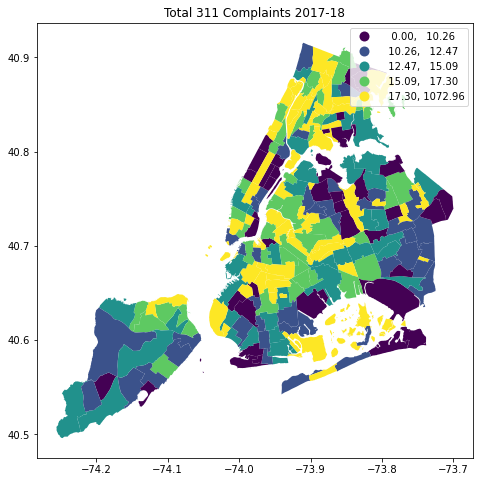

In [58]:
viz_counts_bypop(counts1718, '2017-18')

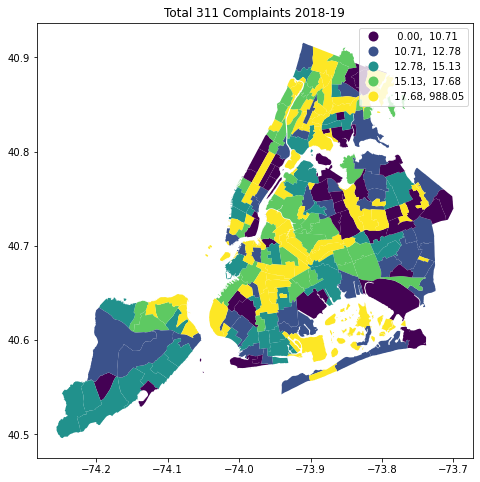

In [59]:
viz_counts_bypop(counts1819, '2018-19')

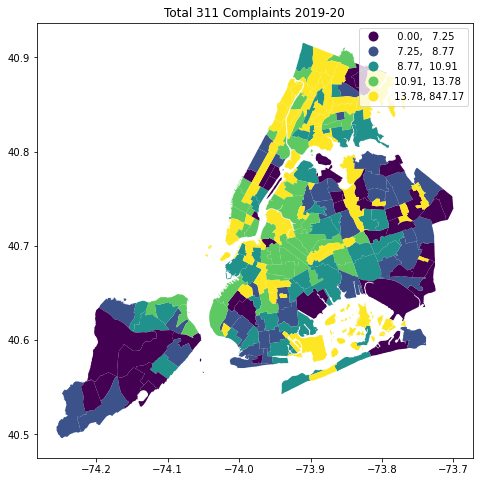

In [60]:
viz_counts_bypop(counts1920, '2019-20')

In [61]:
# normalized by nr. of households

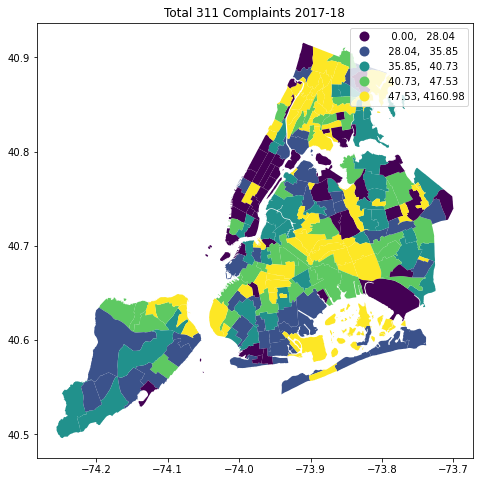

In [62]:
viz_counts_byhousehold(counts1718, '2017-18')

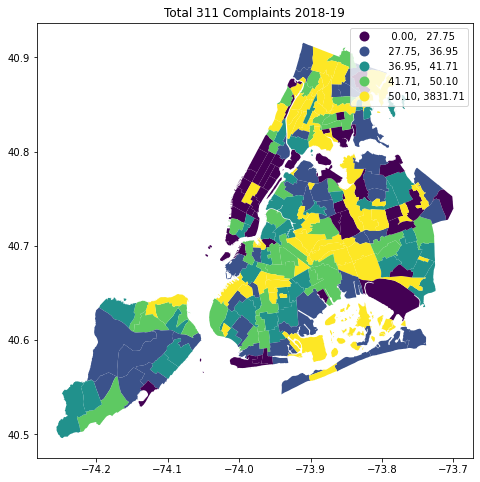

In [63]:
viz_counts_byhousehold(counts1819, '2018-19')

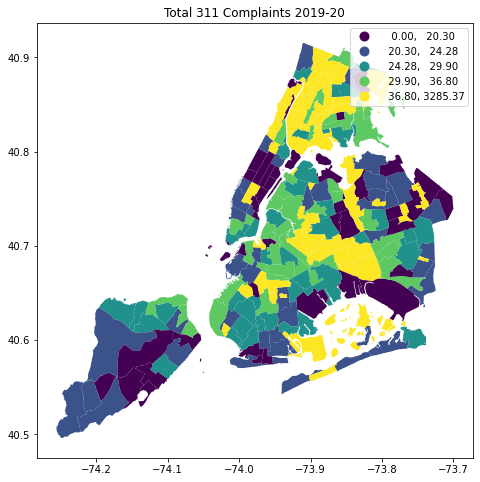

In [64]:
viz_counts_byhousehold(counts1920, '2019-20')

In [65]:
# compare drop / rise of complaint amount

In [66]:
counts_household = counts1718['%Complaints/Househ'].reset_index().merge(counts1819['%Complaints/Househ'].reset_index(), on='NTAName').merge(counts1920['%Complaints/Househ'].reset_index(), on='NTAName')
counts_household = counts_household.rename(columns={'%Complaints/Househ_x':'1718', '%Complaints/Househ_y':'1819', '%Complaints/Househ':'1920'})
counts_household['diff']= (counts_household['1920']-counts_household['1718'])/counts_household['1718']

counts_population = counts1718['%Complaints/Pop'].reset_index().merge(counts1819['%Complaints/Pop'].reset_index(), on='NTAName').merge(counts1920['%Complaints/Pop'].reset_index(), on='NTAName')
counts_population = counts_population.rename(columns={'%Complaints/Pop_x':'1718', '%Complaints/Pop_y':'1819', '%Complaints/Pop':'1920'})
counts_population['diff']= (counts_population['1920']-counts_population['1718'])/counts_population['1718']


/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No handles with labels found to put in legend.


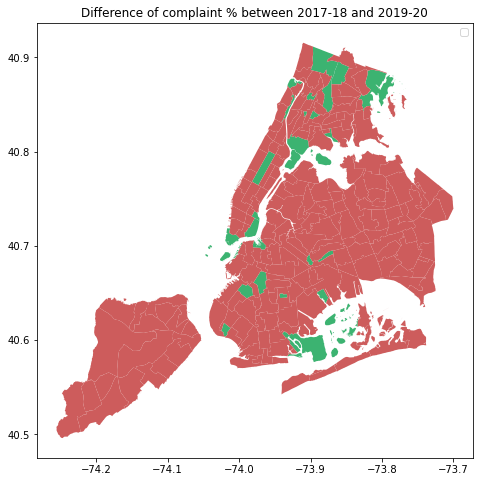

In [67]:
# by household
fig, ax = plt.subplots(1, 1, figsize=(8,8))

plot_map = counts_population[['NTAName','diff']]
plot_map = NYC.merge(plot_map, on='NTAName', how='outer')
plot_map.loc[plot_map['diff'] > 0].plot(column='diff', ax=ax, legend=True, color='mediumseagreen', label='increase')
plot_map.loc[plot_map['diff'] <= 0].plot(column='diff', ax=ax, legend=True, color='indianred', label='decrease')

plt.legend()
plt.title('Difference of complaint % between 2017-18 and 2019-20')
plt.show()

Text(0.5, 1.0, 'Difference of complaint % between 2017-18 and 2019-20')

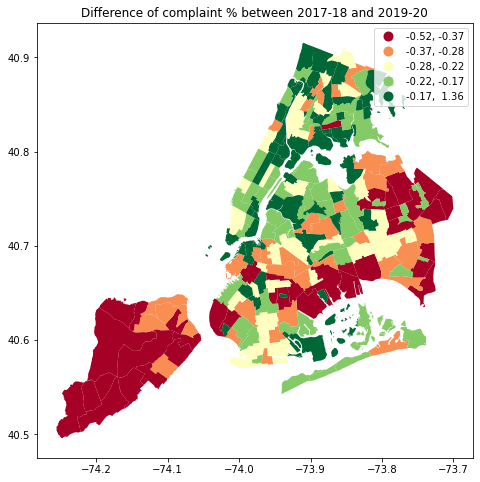

In [68]:
plot_map = counts_population[['NTAName','diff']]
plot_map = NYC.merge(plot_map, on='NTAName', how='outer')
plot_map.plot(figsize=(8,8), column='diff', legend=True, scheme='Quantiles', cmap='RdYlGn')
plt.title('Difference of complaint % between 2017-18 and 2019-20')

# 3. Clustering

In [69]:
def normalize_df(df): 
    df_norm = df.T
    Total=df_norm.sum(axis=1)
    df_norm=df_norm.div(Total, axis=0)
    return df_norm

In [70]:
def k_means_silhouette(time_period_start,time_period_end,range_n_clusters,df):
    for n_clusters in range_n_clusters:
        km = KMeans(n_clusters=n_clusters, random_state=444)
        cluster_labels = km.fit_predict(pd.DataFrame(df.loc[:,time_period_start:time_period_end]))
        silhouette_avg = silhouette_score((pd.DataFrame(df.loc[:,time_period_start:time_period_end])),
                                          labels=cluster_labels)
        print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".\
              format(silhouette_avg))
            
def gaussian_silhouette(time_period_start,time_period_end,range_n_clusters,df):

    for n_clusters in range_n_clusters:
        gmm = GaussianMixture(n_components=n_clusters, random_state=444)
        cluster_labels = gmm.fit_predict(pd.DataFrame(df.loc[:,time_period_start:time_period_end]))
        silhouette_avg = silhouette_score((pd.DataFrame(df.loc[:,time_period_start:time_period_end])),
                                          labels=cluster_labels)
        print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".\
              format(silhouette_avg))
        
def cluster_kmeans(time_period_start,time_period_end,n_cluster,df):
    km = KMeans(n_clusters=n_cluster,random_state=444)
    km.fit(pd.DataFrame(df.loc[:,time_period_start:time_period_end]))
    res=km.predict(pd.DataFrame(df.loc[:,time_period_start:time_period_end]))
    res=pd.concat((pd.Series(df.index),pd.Series(res)),axis=1)
    res = res.rename(columns = {0:'Cluster'})
    return res

def cluster_gaussian(time_period_start,time_period_end,n_clusters,df):
    gmm = GaussianMixture(n_components=n_clusters,random_state=444)
    gmm.fit(pd.DataFrame(df.loc[:,time_period_start:time_period_end]))
    res=gmm.predict(pd.DataFrame(df.loc[:,time_period_start:time_period_end]))
    res=pd.concat((pd.Series(df.index),pd.Series(res)),axis=1)
    res = res.rename(columns = {0:'Cluster'})
    return res

In [71]:
# save 

#complaints_1718_month.to_csv('complaints_1718_month.csv', index=True)
#complaints_1819_month.to_csv('complaints_1819_month.csv', index=True)
#complaints_1920_month.to_csv('complaints_1920_month.csv', index=True)

#complaints_1718_month = pd.read_csv('complaints_1718_month.csv')
#complaints_1819_month = pd.read_csv('complaints_1819_month.csv')
#complaints_1920_month = pd.read_csv('complaints_1920_month.csv')

# open (make sure to change 'Month' column to index)
#complaints_1718_month = pd.read_csv('complaints_1718_month.csv')
#complaints_1819_month = pd.read_csv('complaints_1819_month.csv')
#complaints_1920_month = pd.read_csv('complaints_1920_month.csv')

In [72]:
# normalize complaints

complaints_1718_month_norm = normalize_df(complaints_1718_month)
complaints_1819_month_norm = normalize_df(complaints_1819_month)
complaints_1920_month_norm = normalize_df(complaints_1920_month)

## 3.1 K-Means

### 3.1.1. By month for each year

#### Silhouette Score

In [73]:
date_start_range = ['12-2017','12-2018','12-2019']
date_end_range = ['05-2018','05-2019','05-2020']
dfs = [complaints_1718_month_norm, complaints_1819_month_norm, complaints_1920_month_norm]
for i in range(0,3):
    k_means_silhouette(date_start_range[i],date_end_range[i],range(2,6),dfs[i])
    print('---------------')

For n_clusters = 2, the average silhouette_score is : 0.3278587777391087
For n_clusters = 3, the average silhouette_score is : 0.34507013264670083
For n_clusters = 4, the average silhouette_score is : 0.3331858646032088
For n_clusters = 5, the average silhouette_score is : 0.34114380680185713
---------------
For n_clusters = 2, the average silhouette_score is : 0.38697598980351616
For n_clusters = 3, the average silhouette_score is : 0.3560584296891831
For n_clusters = 4, the average silhouette_score is : 0.3550343871055261
For n_clusters = 5, the average silhouette_score is : 0.31332913899667114
---------------
For n_clusters = 2, the average silhouette_score is : 0.4189465764717086
For n_clusters = 3, the average silhouette_score is : 0.4204326377265803
For n_clusters = 4, the average silhouette_score is : 0.43958960517292456
For n_clusters = 5, the average silhouette_score is : 0.4352622282358854
---------------


Number of clusters = 2 for all years

In [74]:
res_1718 = cluster_kmeans('12-2017','05-2018',2,complaints_1718_month_norm)
res_1819 = cluster_kmeans('12-2018','05-2019',2,complaints_1819_month_norm)
res_1920 = cluster_kmeans('12-2019','05-2020',2,complaints_1920_month_norm)

In [75]:
print(len(res_1718))
print(len(res_1819))
print(len(res_1920))

30
30
30


In [76]:
res_1718.join(res_1819,rsuffix = '_1819').join(res_1920,rsuffix='_1920')

Complaint Type  Cluster  \
0                           APPLIANCE        1   
1                    Blocked Driveway        1   
2                        Building/Use        0   
3                  Consumer Complaint        0   
4                         DOOR/WINDOW        1   
5                   Derelict Vehicles        0   
6                    Dirty Conditions        0   
7                            ELECTRIC        1   
8                            Elevator        1   
9          For Hire Vehicle Complaint        0   
10                            GENERAL        1   
11      General Construction/Plumbing        0   
12                           Graffiti        1   
13                     HEAT/HOT WATER        1   
14         Homeless Person Assistance        1   
15                    Illegal Parking        0   
16  Missed Collection (All Materials)        0   
17                              Noise        0   
18                      PAINT/PLASTER        1   
19                           PLUMBING        1   
20                             Rodent        0   
21                              Sewer        0   
22                 Sidewalk Condition        0   
23                   Street Condition        0   
24             Street Light Condition        0   
25           Traffic Signal Condition        1   
26                       Tree-related        0   
27               UNSANITARY CONDITION        1   
28                         WATER LEAK        1   
29                       Water System        1   

                  Complaint Type_1819  Cluster_1819  \
0                           APPLIANCE             1   
1                    Blocked Driveway             1   
2                        Building/Use             0   
3                  Consumer Complaint             0   
4                         DOOR/WINDOW             1   
5                   Derelict Vehicles             0   
6                    Dirty Conditions             0   
7                            ELECTRIC             1   
8                            Elevator             1   
9          For Hire Vehicle Complaint             0   
10                            GENERAL             1   
11      General Construction/Plumbing             0   
12                           Graffiti             1   
13                     HEAT/HOT WATER             1   
14         Homeless Person Assistance             0   
15                    Illegal Parking             0   
16  Missed Collection (All Materials)             1   
17                              Noise             0   
18                      PAINT/PLASTER             1   
19                           PLUMBING             1   
20                             Rodent             0   
21                              Sewer             0   
22                 Sidewalk Condition             0   
23                   Street Condition             0   
24             Street Light Condition             0   
25           Traffic Signal Condition             1   
26                       Tree-related             0   
27               UNSANITARY CONDITION             1   
28                         WATER LEAK             1   
29                       Water System             1   

                  Complaint Type_1920  Cluster_1920  
0                           APPLIANCE             1  
1                    Blocked Driveway             0  
2                        Building/Use             0  
3                  Consumer Complaint             1  
4                         DOOR/WINDOW             1  
5                   Derelict Vehicles             0  
6                    Dirty Conditions             0  
7                            ELECTRIC             1  
8                            Elevator             0  
9          For Hire Vehicle Complaint             0  
10                            GENERAL             1  
11      General Construction/Plumbing             0  
12                           Graffiti             0  
13        

In [77]:
#kmeans_joined_top30 = res_1718.join(res_1819,rsuffix = '_1819').join(res_1920,rsuffix='_1920')
#kmeans_joined_top30.to_csv('cluster-kmeans-top30.csv')

#### Comparing clusters over time

This explains contingency matrix and rand score relatively well: https://www.tutorialspoint.com/scikit_learn/scikit_learn_clustering_performance_evaluation.htm

In [78]:
#if we need to switch the labels we can use this
#relabel = np.choose(clustering.labels_,[1,0]).astype(np.int64)
#reference: https://stackoverflow.com/questions/60924625/sklearn-k-means-cluster-labels-vs-ground-truth-labels

In [79]:
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import adjusted_rand_score

In [80]:
#method 1
print(contingency_matrix(res_1718['Cluster'],res_1819['Cluster']))
print(adjusted_rand_score(res_1718['Cluster'],res_1819['Cluster']))

[[14  1]
 [ 1 14]]
0.7422222222222222


With this we've validated that using 2018-2019 as a baseline, since the clusters of 2017-2018 are comparable. We can now print out a few visualizations for 2017-2018 clusters but discard it and continue our analysis with 2018-2019. We also need the visualizations of cluster comparison by week, month & by borough as a part of our descriptive/exploratory analysis section

### 3.1.2 By week for each year

In [81]:
complaints_1718_week_norm = normalize_df(complaints_1718_week)
complaints_1819_week_norm = normalize_df(complaints_1819_week)
complaints_1920_week_norm = normalize_df(complaints_1920_week)
year_start = ['2017','2018','2019']
year_end = ['2018','2019','2020']
dfs = [complaints_1718_week_norm, complaints_1819_week_norm, complaints_1920_week_norm]
for i in range(0,3):
    k_means_silhouette(str(year_start[i])+'_week_48',str(year_end[i])+'_week_21',range(2,6),dfs[i])
    print('-------------')

For n_clusters = 2, the average silhouette_score is : 0.270049590183452
For n_clusters = 3, the average silhouette_score is : 0.2724255282940398
For n_clusters = 4, the average silhouette_score is : 0.2763261156671993
For n_clusters = 5, the average silhouette_score is : 0.2893881758571365
-------------
For n_clusters = 2, the average silhouette_score is : 0.253027957055189
For n_clusters = 3, the average silhouette_score is : 0.2554489244603586
For n_clusters = 4, the average silhouette_score is : 0.2566300488721212
For n_clusters = 5, the average silhouette_score is : 0.21408137444731717
-------------
For n_clusters = 2, the average silhouette_score is : 0.3162654451283287
For n_clusters = 3, the average silhouette_score is : 0.33489971709186944
For n_clusters = 4, the average silhouette_score is : 0.3406056227246851
For n_clusters = 5, the average silhouette_score is : 0.32635759281564874
-------------


Number of clusters = 2 for all years

In [82]:
res_1718_wk = cluster_kmeans('2017_week_48','2018_week_21',2,complaints_1718_week_norm)
res_1819_wk = cluster_kmeans('2018_week_48','2019_week_21',2,complaints_1819_week_norm)
res_1920_wk = cluster_kmeans('2019_week_48','2020_week_21',2,complaints_1920_week_norm)

In [83]:
res_1718_wk.join(res_1819_wk,rsuffix = '_1819').join(res_1920_wk,rsuffix='_1920')

Complaint Type  Cluster  \
0                           APPLIANCE        1   
1                    Blocked Driveway        1   
2                        Building/Use        0   
3                  Consumer Complaint        0   
4                         DOOR/WINDOW        1   
5                   Derelict Vehicles        0   
6                    Dirty Conditions        0   
7                            ELECTRIC        1   
8                            Elevator        1   
9          For Hire Vehicle Complaint        0   
10                            GENERAL        1   
11      General Construction/Plumbing        0   
12                           Graffiti        1   
13                     HEAT/HOT WATER        1   
14         Homeless Person Assistance        1   
15                    Illegal Parking        0   
16  Missed Collection (All Materials)        0   
17                              Noise        0   
18                      PAINT/PLASTER        1   
19                           PLUMBING        1   
20                             Rodent        0   
21                              Sewer        0   
22                 Sidewalk Condition        0   
23                   Street Condition        0   
24             Street Light Condition        0   
25           Traffic Signal Condition        1   
26                       Tree-related        0   
27               UNSANITARY CONDITION        1   
28                         WATER LEAK        1   
29                       Water System        1   

                  Complaint Type_1819  Cluster_1819  \
0                           APPLIANCE             0   
1                    Blocked Driveway             1   
2                        Building/Use             1   
3                  Consumer Complaint             1   
4                         DOOR/WINDOW             0   
5                   Derelict Vehicles             1   
6                    Dirty Conditions             1   
7                            ELECTRIC             0   
8                            Elevator             1   
9          For Hire Vehicle Complaint             1   
10                            GENERAL             0   
11      General Construction/Plumbing             1   
12                           Graffiti             0   
13                     HEAT/HOT WATER             0   
14         Homeless Person Assistance             1   
15                    Illegal Parking             1   
16  Missed Collection (All Materials)             0   
17                              Noise             1   
18                      PAINT/PLASTER             0   
19                           PLUMBING             0   
20                             Rodent             1   
21                              Sewer             1   
22                 Sidewalk Condition             1   
23                   Street Condition             1   
24             Street Light Condition             1   
25           Traffic Signal Condition             0   
26                       Tree-related             1   
27               UNSANITARY CONDITION             0   
28                         WATER LEAK             0   
29                       Water System             0   

                  Complaint Type_1920  Cluster_1920  
0                           APPLIANCE             1  
1                    Blocked Driveway             0  
2                        Building/Use             0  
3                  Consumer Complaint             1  
4                         DOOR/WINDOW             1  
5                   Derelict Vehicles             0  
6                    Dirty Conditions             0  
7                            ELECTRIC             1  
8                            Elevator             0  
9          For Hire Vehicle Complaint             0  
10                            GENERAL             1  
11      General Construction/Plumbing             0  
12                           Graffiti             0  
13        

In [84]:
#method 1
print(contingency_matrix(res_1718_wk['Cluster'],res_1819_wk['Cluster']))
print(adjusted_rand_score(res_1718_wk['Cluster'],res_1819_wk['Cluster']))

[[ 1 14]
 [12  3]]
0.5215736040609137


More variability in clusters when looking at them on a weekly level but that's okay, we'll go with monthly since we're looking at a long-ish period of time anyway.

## 3.2. Gaussian

### 3.2.1 By month for each year

In [85]:
date_start_range = ['12-2017','12-2018','12-2019']
date_end_range = ['05-2018','05-2019','05-2020']
dfs = [complaints_1718_month_norm, complaints_1819_month_norm, complaints_1920_month_norm]
for i in range(0,3):
    gaussian_silhouette(date_start_range[i],date_end_range[i],range(2,6),dfs[i])
    print('---------------')

For n_clusters = 2, the average silhouette_score is : 0.4364611350813617
For n_clusters = 3, the average silhouette_score is : 0.5160807052467205
For n_clusters = 4, the average silhouette_score is : 0.3281088273531623
For n_clusters = 5, the average silhouette_score is : 0.3266437077891454
---------------
For n_clusters = 2, the average silhouette_score is : 0.5794942914920481
For n_clusters = 3, the average silhouette_score is : 0.36097970892844705
For n_clusters = 4, the average silhouette_score is : 0.3542026330652332
For n_clusters = 5, the average silhouette_score is : 0.34277377328055836
---------------
For n_clusters = 2, the average silhouette_score is : 0.6250893515497443
For n_clusters = 3, the average silhouette_score is : 0.4180781908334537
For n_clusters = 4, the average silhouette_score is : 0.34163766778574434
For n_clusters = 5, the average silhouette_score is : 0.35987279352129486
---------------


In [86]:
res_1718_gm = cluster_gaussian('12-2017','05-2018',2,complaints_1718_month_norm)
res_1819_gm = cluster_gaussian('12-2018','05-2019',2,complaints_1819_month_norm)
res_1920_gm = cluster_gaussian('12-2019','05-2020',2,complaints_1920_month_norm)

In [87]:
res_1718_gm.join(res_1819_gm,rsuffix = '_1819').join(res_1920_gm,rsuffix='_1920')

Complaint Type  Cluster  \
0                           APPLIANCE        0   
1                    Blocked Driveway        0   
2                        Building/Use        0   
3                  Consumer Complaint        0   
4                         DOOR/WINDOW        0   
5                   Derelict Vehicles        0   
6                    Dirty Conditions        0   
7                            ELECTRIC        0   
8                            Elevator        0   
9          For Hire Vehicle Complaint        0   
10                            GENERAL        0   
11      General Construction/Plumbing        0   
12                           Graffiti        0   
13                     HEAT/HOT WATER        1   
14         Homeless Person Assistance        0   
15                    Illegal Parking        0   
16  Missed Collection (All Materials)        0   
17                              Noise        0   
18                      PAINT/PLASTER        0   
19                           PLUMBING        1   
20                             Rodent        0   
21                              Sewer        0   
22                 Sidewalk Condition        0   
23                   Street Condition        0   
24             Street Light Condition        0   
25           Traffic Signal Condition        0   
26                       Tree-related        0   
27               UNSANITARY CONDITION        0   
28                         WATER LEAK        0   
29                       Water System        1   

                  Complaint Type_1819  Cluster_1819  \
0                           APPLIANCE             0   
1                    Blocked Driveway             0   
2                        Building/Use             0   
3                  Consumer Complaint             0   
4                         DOOR/WINDOW             0   
5                   Derelict Vehicles             0   
6                    Dirty Conditions             0   
7                            ELECTRIC             0   
8                            Elevator             0   
9          For Hire Vehicle Complaint             0   
10                            GENERAL             0   
11      General Construction/Plumbing             0   
12                           Graffiti             0   
13                     HEAT/HOT WATER             1   
14         Homeless Person Assistance             0   
15                    Illegal Parking             0   
16  Missed Collection (All Materials)             0   
17                              Noise             0   
18                      PAINT/PLASTER             0   
19                           PLUMBING             0   
20                             Rodent             0   
21                              Sewer             0   
22                 Sidewalk Condition             0   
23                   Street Condition             0   
24             Street Light Condition             0   
25           Traffic Signal Condition             0   
26                       Tree-related             0   
27               UNSANITARY CONDITION             0   
28                         WATER LEAK             0   
29                       Water System             0   

                  Complaint Type_1920  Cluster_1920  
0                           APPLIANCE             1  
1                    Blocked Driveway             1  
2                        Building/Use             1  
3                  Consumer Complaint             0  
4                         DOOR/WINDOW             1  
5                   Derelict Vehicles             1  
6                    Dirty Conditions             1  
7                            ELECTRIC             1  
8                            Elevator             1  
9          For Hire Vehicle Complaint             1  
10                            GENERAL             1  
11      General Construction/Plumbing             1  
12                           Graffiti             1  
13        

### 3.2.2 By week for each year

In [88]:
year_start = ['2017','2018','2019']
year_end = ['2018','2019','2020']
dfs = [complaints_1718_week_norm, complaints_1819_week_norm, complaints_1920_week_norm]

for i in range(0,3):
    gaussian_silhouette(str(year_start[i])+'_week_48',str(year_end[i])+'_week_21',range(2,6),dfs[i])
    print('-------------')

For n_clusters = 2, the average silhouette_score is : 0.5819549554869103
For n_clusters = 3, the average silhouette_score is : 0.5114660547399564
For n_clusters = 4, the average silhouette_score is : 0.2763261156671993
For n_clusters = 5, the average silhouette_score is : 0.27228762525559536
-------------
For n_clusters = 2, the average silhouette_score is : 0.5347409016450392
For n_clusters = 3, the average silhouette_score is : 0.5152530730506123
For n_clusters = 4, the average silhouette_score is : 0.24645476438642297
For n_clusters = 5, the average silhouette_score is : 0.2345363912129529
-------------
For n_clusters = 2, the average silhouette_score is : 0.6026320097790323
For n_clusters = 3, the average silhouette_score is : 0.31406333490846144
For n_clusters = 4, the average silhouette_score is : 0.2402301871311856
For n_clusters = 5, the average silhouette_score is : 0.22784857456179244
-------------


In [89]:
res_1718_wk_gm = cluster_gaussian('2017_week_48','2018_week_21',2,complaints_1718_week_norm)
res_1819_wk_gm = cluster_gaussian('2018_week_48','2019_week_21',2,complaints_1819_week_norm)
res_1920_wk_gm = cluster_gaussian('2019_week_48','2020_week_21',2,complaints_1920_week_norm)

In [90]:
res_1718_wk_gm.join(res_1819_wk_gm,rsuffix = '_1819').join(res_1920_wk_gm,rsuffix='_1920')

Complaint Type  Cluster  \
0                           APPLIANCE        0   
1                    Blocked Driveway        0   
2                        Building/Use        0   
3                  Consumer Complaint        0   
4                         DOOR/WINDOW        0   
5                   Derelict Vehicles        0   
6                    Dirty Conditions        0   
7                            ELECTRIC        0   
8                            Elevator        0   
9          For Hire Vehicle Complaint        0   
10                            GENERAL        0   
11      General Construction/Plumbing        0   
12                           Graffiti        0   
13                     HEAT/HOT WATER        1   
14         Homeless Person Assistance        0   
15                    Illegal Parking        0   
16  Missed Collection (All Materials)        0   
17                              Noise        0   
18                      PAINT/PLASTER        0   
19                           PLUMBING        0   
20                             Rodent        0   
21                              Sewer        0   
22                 Sidewalk Condition        0   
23                   Street Condition        0   
24             Street Light Condition        0   
25           Traffic Signal Condition        0   
26                       Tree-related        0   
27               UNSANITARY CONDITION        0   
28                         WATER LEAK        0   
29                       Water System        0   

                  Complaint Type_1819  Cluster_1819  \
0                           APPLIANCE             0   
1                    Blocked Driveway             0   
2                        Building/Use             0   
3                  Consumer Complaint             0   
4                         DOOR/WINDOW             0   
5                   Derelict Vehicles             0   
6                    Dirty Conditions             0   
7                            ELECTRIC             0   
8                            Elevator             0   
9          For Hire Vehicle Complaint             0   
10                            GENERAL             0   
11      General Construction/Plumbing             0   
12                           Graffiti             1   
13                     HEAT/HOT WATER             0   
14         Homeless Person Assistance             0   
15                    Illegal Parking             0   
16  Missed Collection (All Materials)             0   
17                              Noise             0   
18                      PAINT/PLASTER             0   
19                           PLUMBING             0   
20                             Rodent             0   
21                              Sewer             0   
22                 Sidewalk Condition             0   
23                   Street Condition             0   
24             Street Light Condition             0   
25           Traffic Signal Condition             0   
26                       Tree-related             0   
27               UNSANITARY CONDITION             0   
28                         WATER LEAK             0   
29                       Water System             0   

                  Complaint Type_1920  Cluster_1920  
0                           APPLIANCE             1  
1                    Blocked Driveway             1  
2                        Building/Use             1  
3                  Consumer Complaint             0  
4                         DOOR/WINDOW             1  
5                   Derelict Vehicles             1  
6                    Dirty Conditions             1  
7                            ELECTRIC             1  
8                            Elevator             1  
9          For Hire Vehicle Complaint             1  
10                            GENERAL             1  
11      General Construction/Plumbing             1  
12                           Graffiti             1  
13        

Again, severe imbalance here, kmeans is the way to go.

## 3.3 Clusters over time

In [91]:
# def time_period_viz(time_period_start,time_period_end,df_norm,res):
def time_period_viz(time_period_start,time_period_end,df_norm,res, size_1, size_2):

    clusters = df_norm.loc[:,time_period_start:time_period_end]
    res = res.set_index('Complaint Type')
    clusters = res.join(clusters)
    clusters_means = clusters.groupby(by='Cluster').mean()

    #plt.figure(figsize=(6,5))
    plt.figure(figsize=(size_1,size_2))
    plt.grid(True, alpha = 0.5)
    for i in range(len(clusters_means)):
        plt.plot(clusters_means.columns,clusters_means.iloc[i], label = ('Cluster'+str(i)))

    plt.ylabel('Mean of Proportions')
    plt.xlabel('Period')
    plt.xticks(rotation = 90)
    plt.title('Time from '+time_period_start+' to '+time_period_end)
    plt.legend()
    plt.show()

### 3.3.1. By month

In [92]:
date_start_range = ['12-2017','12-2018','12-2019']
date_end_range = ['05-2018','05-2019','05-2020']
dfs = [complaints_1718_month_norm, complaints_1819_month_norm, complaints_1920_month_norm]

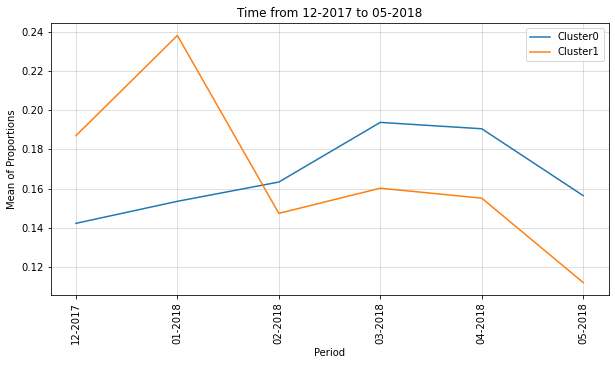

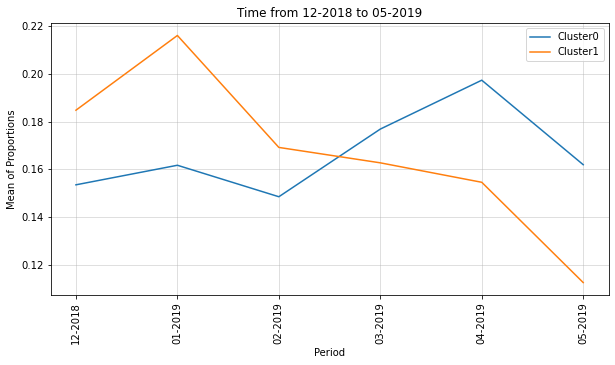

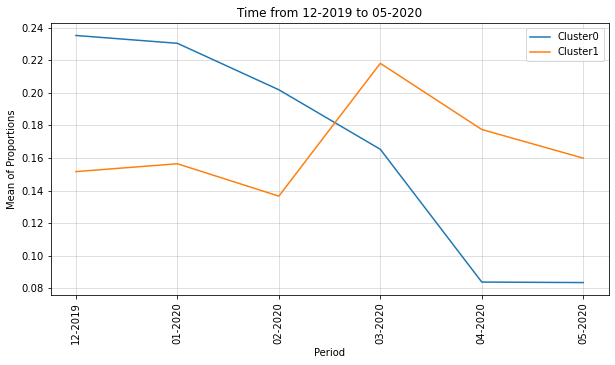

In [93]:
res_list = [res_1718,res_1819,res_1920]
for i in range(0,3):
    time_period_viz(date_start_range[i],date_end_range[i],dfs[i],res_list[i], 10, 5)

### 3.3.2. By week

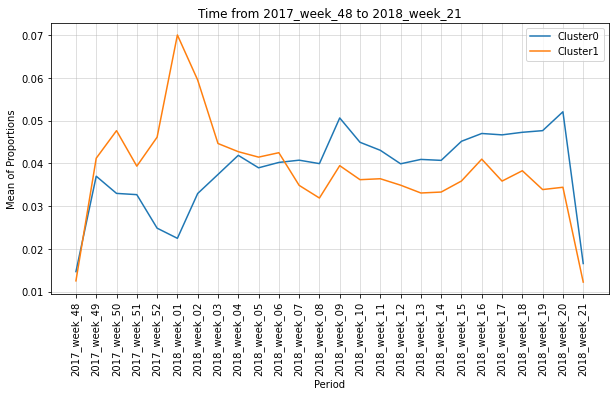

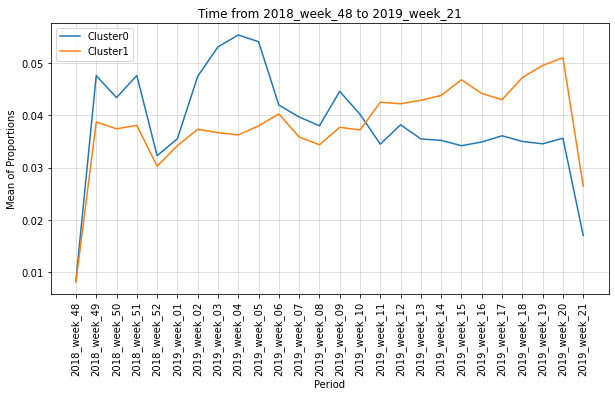

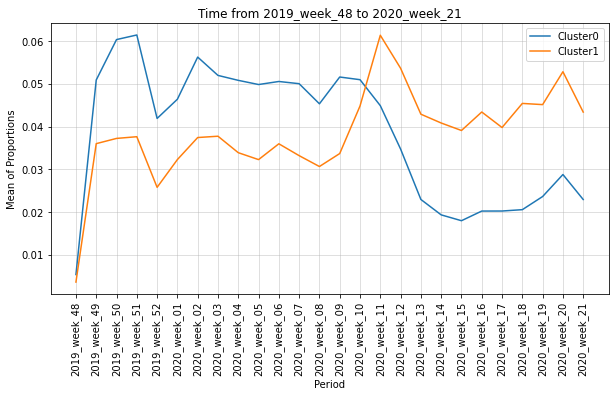

In [94]:
year_start = ['2017','2018','2019']
year_end = ['2018','2019','2020']
dfs = [complaints_1718_week_norm, complaints_1819_week_norm, complaints_1920_week_norm]

res_list = [res_1718_wk,res_1819_wk,res_1920_wk]
for i in range(0,3):
    time_period_viz(str(year_start[i])+'_week_48',str(year_end[i])+'_week_21',dfs[i],res_list[i], 10, 5)

## 3.4 Clusters by borough

In [95]:
joined_complaints1718_top30 = joined_complaints1718.loc[(joined_complaints1718['Complaint Type'].isin(top30_complaint_set))]
joined_complaints1819_top30 = joined_complaints1819.loc[(joined_complaints1819['Complaint Type'].isin(top30_complaint_set))]
joined_complaints1920_top30 = joined_complaints1920.loc[(joined_complaints1920['Complaint Type'].isin(top30_complaint_set))]

In [96]:
#edit data frames from above to have complaint type by borough
#group complaints by type and borough. Note: we will only look at complaints in top30_complaint_set

complaints_1718_borough = joined_complaints1718_top30.groupby(['Complaint Type', 'BoroName'])['Unique Key'].count().unstack(fill_value=0).rename_axis(None, axis=1)
complaints_1819_borough = joined_complaints1819_top30.groupby(['Complaint Type', 'BoroName'])['Unique Key'].count().unstack(fill_value=0).rename_axis(None, axis=1)
complaints_1920_borough = joined_complaints1920_top30.groupby(['Complaint Type', 'BoroName'])['Unique Key'].count().unstack(fill_value=0).rename_axis(None, axis=1)

#normalize
complaints_1718_borough_norm = normalize_df(complaints_1718_borough)
complaints_1819_borough_norm = normalize_df(complaints_1819_borough)
complaints_1920_borough_norm = normalize_df(complaints_1920_borough)

#transpose
complaints_1718_borough_norm = complaints_1718_borough_norm.T
complaints_1819_borough_norm = complaints_1819_borough_norm.T
complaints_1920_borough_norm = complaints_1920_borough_norm.T

In [97]:
#edit the functions so that we cluster by borough, not time frame
def k_means_silhouette_borough(borough,range_n_clusters,df):
    for n_clusters in range_n_clusters:
        km = KMeans(n_clusters=n_clusters, random_state=444)
        cluster_labels = km.fit_predict(pd.DataFrame(df.loc[:,borough]))
        silhouette_avg = silhouette_score((pd.DataFrame(df.loc[:,borough])),
                                          labels=cluster_labels)
        print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".\
              format(silhouette_avg))
        
def gaussian_silhouette_borough(borough,range_n_clusters,df):

    for n_clusters in range_n_clusters:
        gmm = GaussianMixture(n_components=n_clusters, random_state=444)
        cluster_labels = gmm.fit_predict(pd.DataFrame(df.loc[:,borough]))
        silhouette_avg = silhouette_score((pd.DataFrame(df.loc[:,borough])),
                                          labels=cluster_labels)
        print("For n_clusters = {},".format(n_clusters)+" the average silhouette_score is : {}".\
              format(silhouette_avg))
        
def cluster_kmeans_borough(borough,n_cluster,df):
    km = KMeans(n_clusters=n_cluster)
    km.fit(pd.DataFrame(df.loc[:,borough]))
    res=km.predict(pd.DataFrame(df.loc[:,borough]))
    res=pd.concat((pd.Series(df.index),pd.Series(res)),axis=1)
    res = res.rename(columns = {0:'Cluster'})
    return res

def cluster_gaussian_borough(borough,n_clusters,df):
    gmm = GaussianMixture(n_components=n_clusters)
    gmm.fit(pd.DataFrame(df.loc[:,borough]))
    res=gmm.predict(pd.DataFrame(df.loc[:,borough]))
    res=pd.concat((pd.Series(df.index),pd.Series(res)),axis=1)
    res = res.rename(columns = {0:'Cluster'})
    return res

In [98]:
borough = ['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
dfs = [complaints_1718_borough_norm, complaints_1819_borough_norm, complaints_1920_borough_norm]
for i in range(0,3):
    k_means_silhouette_borough(borough[i],range(2,6),dfs[i])
    print('---------------')

For n_clusters = 2, the average silhouette_score is : 0.8847800506978207
For n_clusters = 3, the average silhouette_score is : 0.6967998336452841
For n_clusters = 4, the average silhouette_score is : 0.6682468240060516
For n_clusters = 5, the average silhouette_score is : 0.5308082444737531
---------------
For n_clusters = 2, the average silhouette_score is : 0.8225039044794576
For n_clusters = 3, the average silhouette_score is : 0.801866561741877
For n_clusters = 4, the average silhouette_score is : 0.5699391281878585
For n_clusters = 5, the average silhouette_score is : 0.5269775373105884
---------------
For n_clusters = 2, the average silhouette_score is : 0.9045304940492592
For n_clusters = 3, the average silhouette_score is : 0.8442772307705645
For n_clusters = 4, the average silhouette_score is : 0.6147578405653401
For n_clusters = 5, the average silhouette_score is : 0.56786530491998
---------------


In [99]:
def viz_borough_km(df_norm,n_clusters,time_period):
    
    km = KMeans(random_state=1,n_clusters=n_clusters)
    cl = km.fit(df_norm)
    label_borough = cl.labels_
    res_test = df_norm.copy()
    res_test['cluster'] = label_borough
    plot_borough = res_test.groupby('cluster').mean().transpose()

    fig, ax = plt.subplots(figsize=(10,5))
    plot_borough.plot(ax=ax, grid=True, xticks=range(6), ylim=(0,0.45))
    #plot_borough.plot(ax=ax, grid=True, xticks=range(6))
    plt.xticks(fontsize=12)
    plt.title('Time from '+str(time_period),size=20)
    ax.set_ylabel('Mean of Proportions', fontsize=20)
    plt.show()

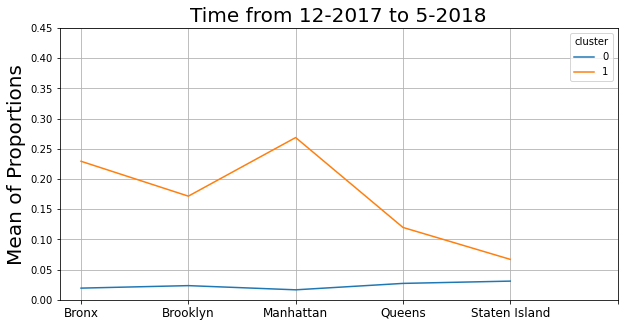

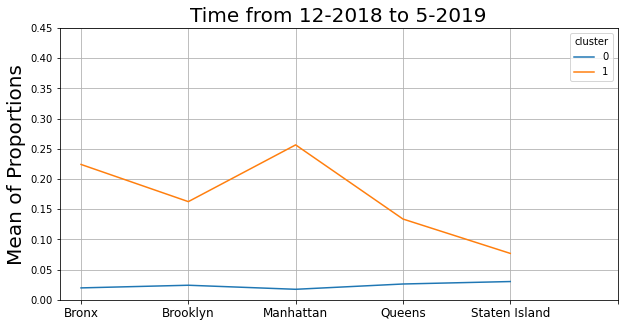

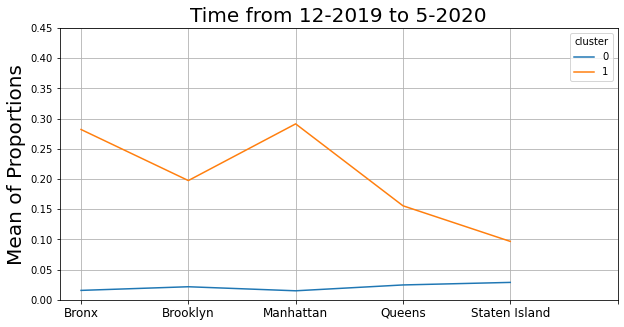

In [100]:
#clustering by borough for kmeans
dfs_borough = [complaints_1718_borough_norm,complaints_1819_borough_norm,complaints_1920_borough_norm]
time_period = ['12-2017 to 5-2018','12-2018 to 5-2019','12-2019 to 5-2020']
for i in range(0,3):
    viz_borough_km(dfs_borough[i], 2,time_period[i])

## 3.5. Cluster composition

In [101]:
complaints_1718_month_norm.head()

Month                12-2017   01-2018   02-2018   03-2018   04-2018   05-2018
Complaint Type                                                                
APPLIANCE           0.171948  0.217979  0.160440  0.174450  0.154436  0.120747
Blocked Driveway    0.198059  0.183482  0.147373  0.175212  0.167653  0.128221
Building/Use        0.151220  0.166941  0.172631  0.178620  0.184159  0.146429
Consumer Complaint  0.159281  0.174052  0.160674  0.170847  0.190914  0.144231
DOOR/WINDOW         0.182660  0.245478  0.152107  0.162310  0.148412  0.109034

In [102]:
res_1718.head()

Complaint Type  Cluster
0           APPLIANCE        1
1    Blocked Driveway        1
2        Building/Use        0
3  Consumer Complaint        0
4         DOOR/WINDOW        1

In [103]:
clusterChar_1718 = complaints_1718_month_norm.reset_index().\
                merge(res_1718,left_on='Complaint Type',right_on='Complaint Type')
clusterChar_1819 = complaints_1819_month_norm.reset_index().\
                merge(res_1819,left_on='Complaint Type',right_on='Complaint Type')
clusterChar_1920 = complaints_1920_month_norm.reset_index().\
                merge(res_1920,left_on='Complaint Type',right_on='Complaint Type')

In [104]:
# save files
#clusterChar_1718.to_csv('clusterChar_1718.csv')
#clusterChar_1819.to_csv('clusterChar_1819.csv')
#clusterChar_1920.to_csv('clusterChar_1920.csv')

# read files
# clusterChar1718 = pd.read_csv('clusterChar_1718.csv')
# clusterChar_1819 = pd.read_csv('clusterChar_1819.csv')
# clusterChar_1920 = pd.read_csv('clusterChar_1920.csv')

In [105]:
def prep_df_cluster(df, i):
    df_cluster = df.loc[df['Cluster']==i]
    df_cluster = df_cluster.drop(['Cluster'],axis=1)
    df_cluster = df_cluster.T
    df_cluster = df_cluster.reset_index()
    df_cluster = df_cluster.rename(columns=df_cluster.iloc[0])
    df_cluster = df_cluster[1:]
    df_cluster = df_cluster.reset_index()
    df_cluster = df_cluster.drop(['index'],axis=1)
    df_cluster = df_cluster.rename(columns ={'Complaint Type':'Month'})
    return df_cluster

In [106]:
#Source code: https://www.python-graph-gallery.com/391-radar-chart-with-several-individuals
def make_spider_overlapped_multiple(data, i, title):

    # number of variable
    categories=list(data)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(1,3,i, polar=True, )
    #ax = plt.subplot(111, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    

    # Draw one axe per variable + add labels labels yet
    ax.xaxis.set_tick_params(pad=30,rotation=0) #we can adjust padding and rotation to try and fix label issue
    plt.xticks(angles[:-1], categories, color='grey', size=12)

    # Draw ylabels
    
    ax.set_rlabel_position(0)
    plt.yticks([0.1,0.2,0.3, 0.4], ["0.1","0.2","0.3","0.4"], color="grey", size=9)
    #ax.set_rlabel_position(0)
    #plt.yticks(color="grey", size=7)
    #plt.ylim(np.linspace(data.iloc[:,1:].min().min(), data.iloc[:,1:].max().max(), 2))
    
    my_palette = plt.cm.get_cmap("coolwarm", len(data.index))
    for row in range(0, len(data.index)): 
        color= my_palette(row)
        values=data.loc[row].drop('Month').values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=color, linewidth=1.5, linestyle='solid', label=data['Month'][row])

    # legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),fancybox=True, shadow=False, ncol=3, fontsize=14)

    # Add a title
    plt.title(title, size=16, color='black', y=1.1,pad=45)

In [107]:
def make_spider_overlapped_multiple2(data, title):

    # number of variable
    categories=list(data)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    ax.xaxis.set_tick_params(pad=15) #we can adjust padding and rotation to try and fix label issue
    plt.xticks(angles[:-1], categories, color='grey', size=12)
    
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles[:-1]))):

        angle_rad=angles[:-1][i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)
    
    # Draw ylabels    
    ax.set_rlabel_position(0)
    plt.yticks([0.1,0.2,0.3, 0.4], ["0.1","0.2","0.3","0.4"], color="grey", size=7)
    
    my_palette = plt.cm.get_cmap("coolwarm", len(data.index))
    for row in range(0, len(data.index)): 
        color= my_palette(row)
        values=data.loc[row].drop('Month').values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, color=color, linewidth=1.5, linestyle='solid', label=data['Month'][row])

    # legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),fancybox=True, shadow=False, ncol=3, fontsize=14)

    # Add a title
    plt.title(title, size=16, color='black', y=1.1,pad=45)

In [108]:
# 1 viz per row

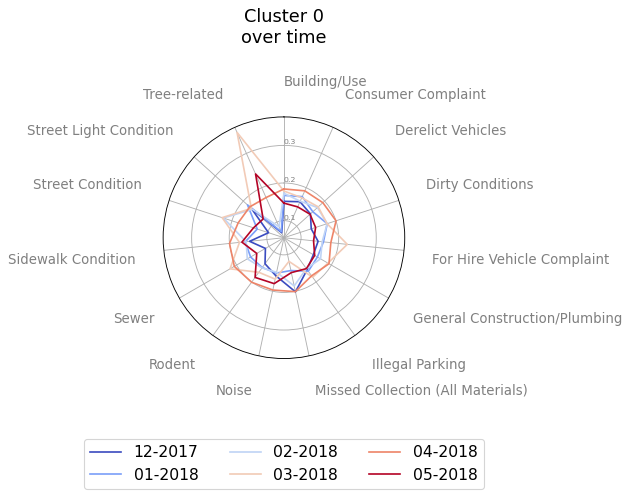

In [109]:
# 2017-18 - CLUSTER 0

cluster0_1718 = prep_df_cluster(clusterChar_1718, 0)
cluster1_1718 = prep_df_cluster(clusterChar_1718, 1)

# row-wise
my_dpi=80 #Note: changed this value
plt.figure(figsize=(4,4), dpi=my_dpi)
make_spider_overlapped_multiple2(cluster0_1718, title='Cluster 0\nover time')    
#make_spider_overlapped_multiple2(cluster1_1718, title='Cluster 1\nover time')

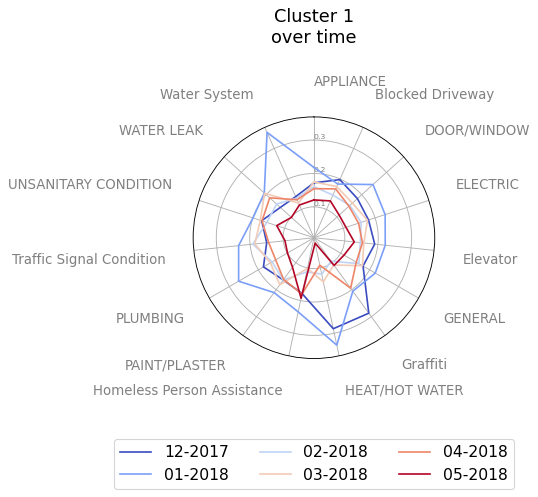

In [110]:
# 2017-18 - CLUSTER 1

cluster0_1718 = prep_df_cluster(clusterChar_1718, 0)
cluster1_1718 = prep_df_cluster(clusterChar_1718, 1)

# row-wise
my_dpi=80 #Note: changed this value
plt.figure(figsize=(4,4), dpi=my_dpi)
make_spider_overlapped_multiple2(cluster1_1718, title='Cluster 1\nover time')    

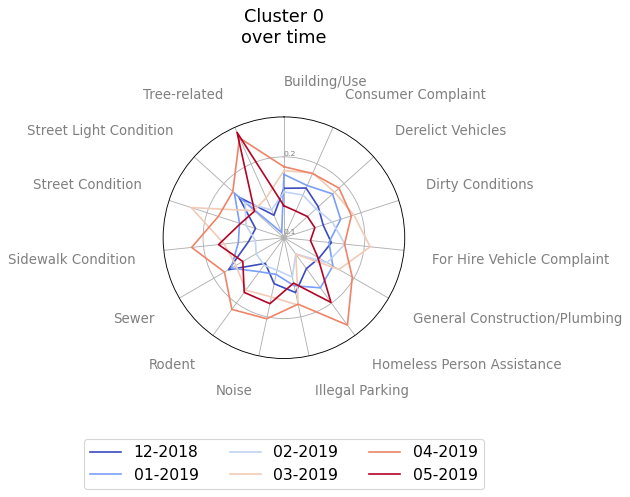

In [111]:
# 2018-19 CLUSTER 0

cluster0_1819 = prep_df_cluster(clusterChar_1819, 0)
cluster1_1819 = prep_df_cluster(clusterChar_1819, 1)

# row-wise
my_dpi=80 #Note: changed this value
plt.figure(figsize=(4,4), dpi=my_dpi)
make_spider_overlapped_multiple2(cluster0_1819, title='Cluster 0\nover time')    

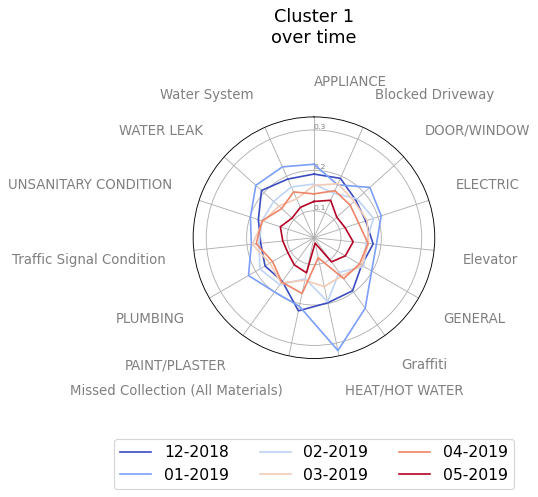

In [112]:
# 2018-19 CLUSTER 1

cluster0_1819 = prep_df_cluster(clusterChar_1819, 0)
cluster1_1819 = prep_df_cluster(clusterChar_1819, 1)

# row-wise
my_dpi=80 #Note: changed this value
plt.figure(figsize=(4,4), dpi=my_dpi)
make_spider_overlapped_multiple2(cluster1_1819, title='Cluster 1\nover time')

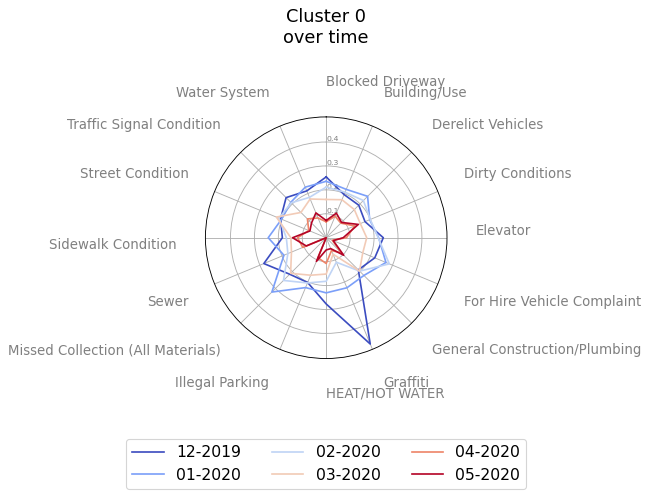

In [113]:
# 2019-20 CLUSTER 0

cluster0_1920 = prep_df_cluster(clusterChar_1920, 0)
cluster1_1920 = prep_df_cluster(clusterChar_1920, 1)

# row-wise
my_dpi=80 #Note: changed this value
plt.figure(figsize=(4,4), dpi=my_dpi)
make_spider_overlapped_multiple2(cluster0_1920, title='Cluster 0\nover time')    

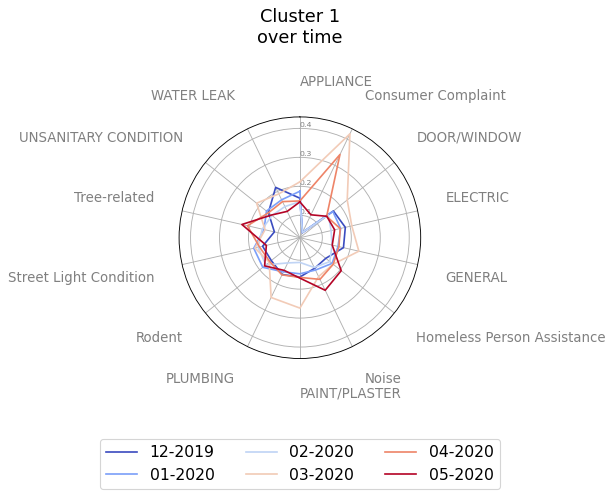

In [114]:
# 2019-20 CLUSTER 1

cluster0_1920 = prep_df_cluster(clusterChar_1920, 0)
cluster1_1920 = prep_df_cluster(clusterChar_1920, 1)

# row-wise
my_dpi=80 #Note: changed this value
plt.figure(figsize=(4,4), dpi=my_dpi)
make_spider_overlapped_multiple2(cluster1_1920, title='Cluster 1\nover time')    

In [115]:
# 2 vizs per row

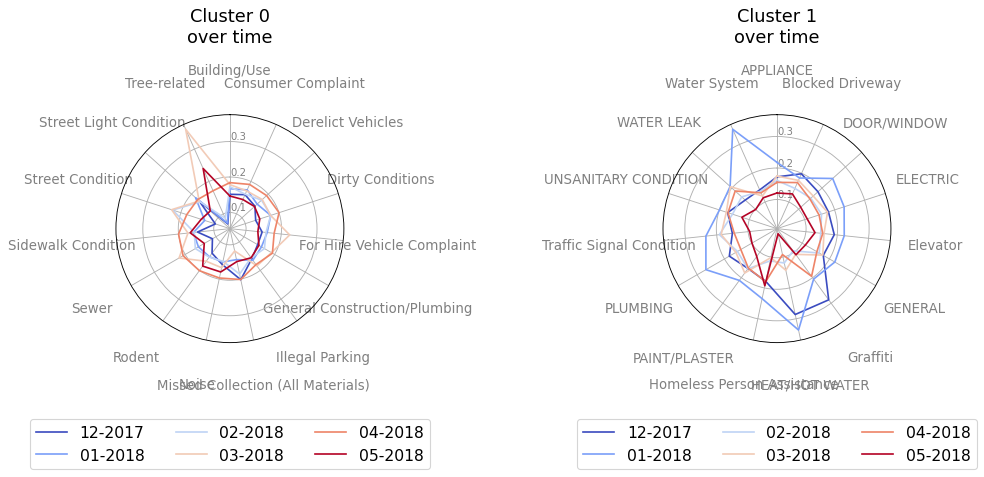

In [116]:
# 2017-18

cluster0_1718 = prep_df_cluster(clusterChar_1718, 0)
cluster1_1718 = prep_df_cluster(clusterChar_1718, 1)

# row-wise
my_dpi=80 #Note: changed this value
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider_overlapped_multiple(cluster0_1718,1, title='Cluster 0\nover time')    
make_spider_overlapped_multiple(cluster1_1718,3, title='Cluster 1\nover time')

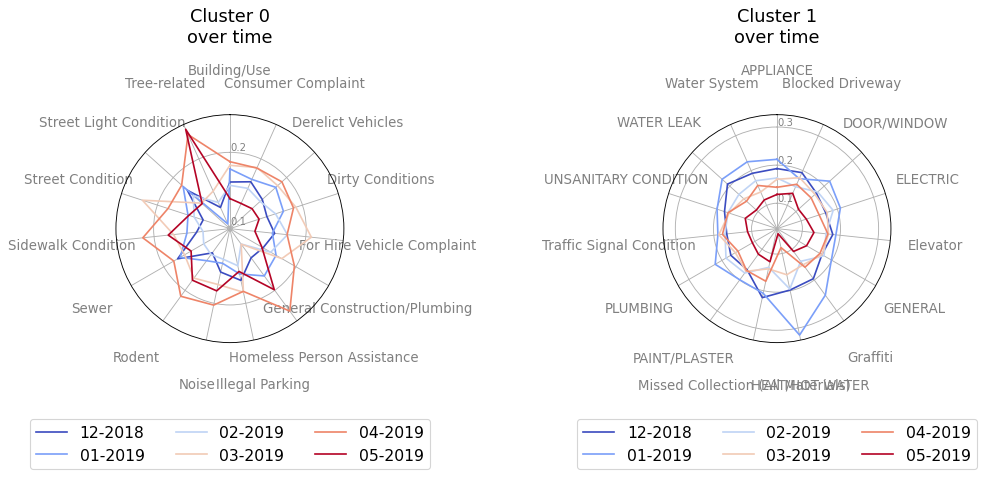

In [117]:
# 2018-19

cluster0_1819 = prep_df_cluster(clusterChar_1819, 0)
cluster1_1819 = prep_df_cluster(clusterChar_1819, 1)

# row-wise
my_dpi=80 #Note: changed this value
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider_overlapped_multiple(cluster0_1819,1, title='Cluster 0\nover time')    
make_spider_overlapped_multiple(cluster1_1819,3, title='Cluster 1\nover time')

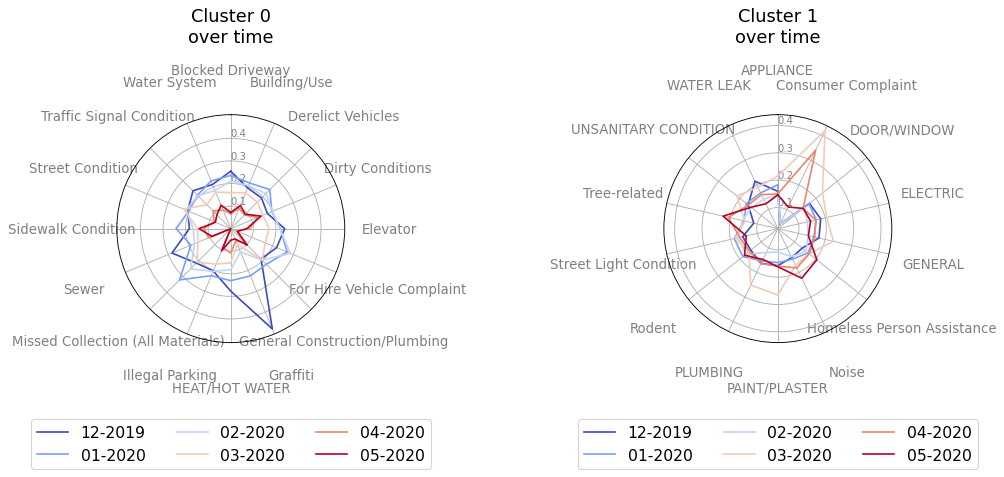

In [118]:
# 2019-20

cluster0_1920 = prep_df_cluster(clusterChar_1920, 0)
cluster1_1920 = prep_df_cluster(clusterChar_1920, 1)

# row-wise
my_dpi=80 #Note: changed this value
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
make_spider_overlapped_multiple(cluster0_1920,1, title='Cluster 0\nover time')    
make_spider_overlapped_multiple(cluster1_1920,3, title='Cluster 1\nover time')

Take a closer look into cluster 18-19

In [119]:
#Source code: https://www.python-graph-gallery.com/392-use-faceting-for-radar-chart
def make_spider(data, row, title, color):

    # number of variable
    categories=list(data)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

    # Draw one axe per variable + add labels labels yet
    ax.xaxis.set_tick_params(pad=25,rotation=0) #we can adjust padding and rotation to try and fix label issue
    plt.xticks(angles[:-1], categories, color='grey', size=10)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.1,0.2,0.3], ["0.1","0.2","0.3"], color="grey", size=7)
    plt.ylim(0,0.4)

    # values
    values=data.loc[row].drop('Month').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Create a color palette:
    #my_palette = plt.cm.get_cmap("Set2", len(data.index))
    
    # Add a title
    plt.title(title, size=12, color='black', y=1.1,pad=25)

In [120]:
# cluster 0 - 2018-19

In [121]:
cluster0_1819

Month Building/Use Consumer Complaint Derelict Vehicles Dirty Conditions  \
0  12-2018     0.159858           0.166184          0.155714         0.149384   
1  01-2019     0.177565           0.169691          0.180291         0.172845   
2  02-2019     0.155329           0.156426          0.151794         0.161698   
3  03-2019     0.182425           0.187224          0.183685         0.190603   
4  04-2019     0.187366           0.186461           0.19141         0.187233   
5  05-2019     0.137457           0.134014          0.137106         0.138237   

  For Hire Vehicle Complaint General Construction/Plumbing  \
0                    0.15764                       0.14859   
1                   0.154513                      0.168846   
2                   0.174982                      0.160556   
3                   0.207534                      0.177863   
4                   0.174556                      0.197479   
5                   0.130775                      0.146667   

  Homeless Person Assistance Illegal Parking     Noise    Rodent     Sewer  \
0                   0.145528        0.168319  0.156815  0.137226  0.178408   
1                   0.175846        0.159411  0.144661  0.150341  0.174505   
2                   0.122452        0.148098  0.139155  0.140073  0.137674   
3                   0.122621         0.18472  0.174039  0.179495  0.167591   
4                    0.23463        0.183475  0.202514  0.209848  0.184432   
5                   0.198922        0.155978  0.182816  0.183017   0.15739   

  Sidewalk Condition Street Condition Street Light Condition Tree-related  
0           0.142018         0.134854                0.17433     0.128177  
1           0.155278         0.156374               0.181994     0.103757  
2           0.133353         0.147585               0.163449     0.135541  
3           0.173435         0.221229               0.148327      0.15239  
4           0.215249         0.184807               0.184597     0.236178  
5           0.180668         0.155151               0.147303     0.243957

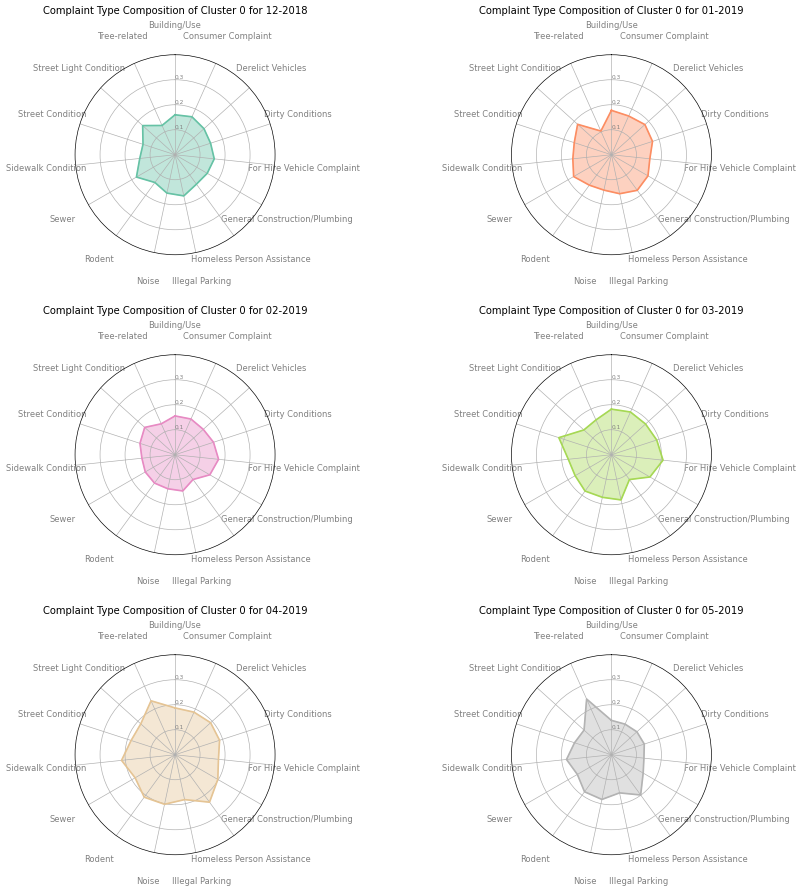

In [122]:
my_dpi=60 #Note: changed this value
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

for row in range(0, len(cluster1_1920.index)):
    my_palette = plt.cm.get_cmap("Set2", len(cluster0_1819.index))
    make_spider(cluster0_1819, row=row,title='Complaint Type Composition of Cluster 0 for '+cluster0_1819['Month'][row], color=my_palette(row))

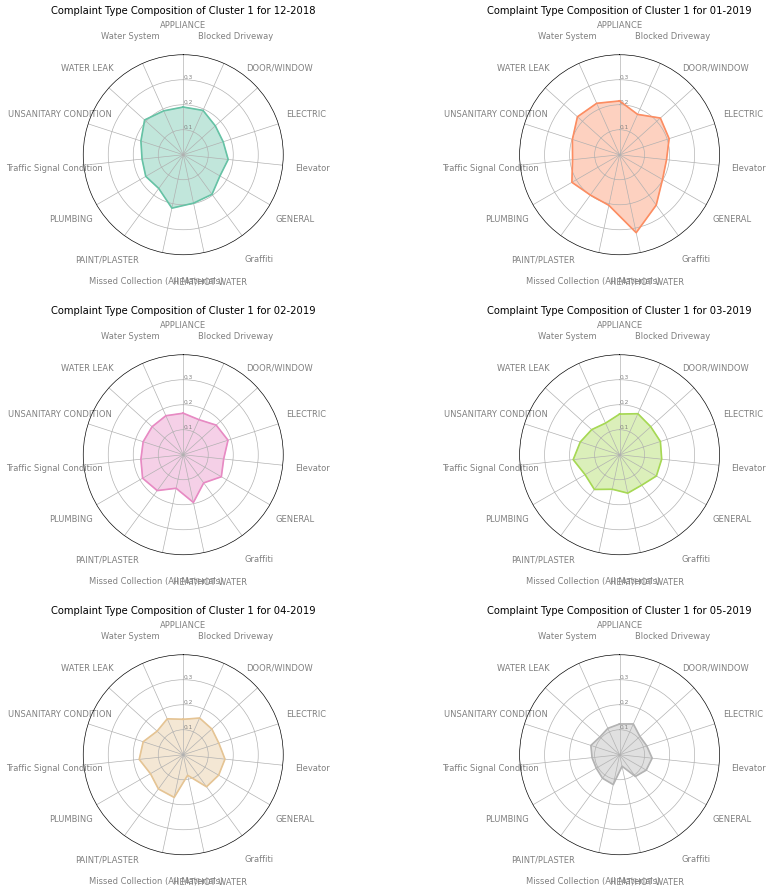

In [123]:
my_dpi=60 #Note: changed this value
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

for row in range(0, len(cluster1_1920.index)):
    my_palette = plt.cm.get_cmap("Set2", len(cluster1_1819.index))
    make_spider(cluster1_1819, row=row,title='Complaint Type Composition of Cluster 1 for '+cluster1_1819['Month'][row], color=my_palette(row))

# 4. Decision Trees

## 4.1 Data preparation

#### Create lists for each cluster for each year containing their corresponding complaint types

In [124]:
C0_1819 = list(res_1819.loc[res_1819['Cluster']==0]['Complaint Type'])
C1_1819 = list(res_1819.loc[res_1819['Cluster']==1]['Complaint Type'])
C0_1920 = list(res_1920.loc[res_1920['Cluster']==0]['Complaint Type'])
C1_1920 = list(res_1920.loc[res_1920['Cluster']==1]['Complaint Type'])

In [125]:
joined_complaints1819.loc[joined_complaints1819['Complaint Type'].isin(C0_1819),'Cluster'] = 0
joined_complaints1819.loc[joined_complaints1819['Complaint Type'].isin(C1_1819),'Cluster'] = 1
joined_complaints1920.loc[joined_complaints1819['Complaint Type'].isin(C0_1920),'Cluster'] = 0
joined_complaints1920.loc[joined_complaints1819['Complaint Type'].isin(C1_1920),'Cluster'] = 1

In [126]:
joined_complaints1920.head()

Unique Key Created Date             Closed Date Agency  \
0    46124131   2020-05-04  05/04/2020 01:25:07 PM   NYPD   
1    45500881   2020-01-29  01/31/2020 12:00:00 PM   DSNY   
2    45326146   2020-01-05  01/06/2020 12:00:00 PM   DSNY   
3    46124650   2020-05-04  05/04/2020 12:42:22 PM   NYPD   
4    46116054   2020-05-03  05/03/2020 03:56:40 PM   NYPD   

                       Agency Name                     Complaint Type  \
0  New York City Police Department        Non-Emergency Police Matter   
1             BCC - Brooklyn South  Missed Collection (All Materials)   
2             BCC - Brooklyn South  Missed Collection (All Materials)   
3  New York City Police Department                              Noise   
4  New York City Police Department        Non-Emergency Police Matter   

                   Descriptor               Location Type  Incident Zip  \
0           Social Distancing  Residential Building/House         11218   
1         1 Missed Collection                    Sidewalk         11218   
2  1RG Missed Recycling Paper                    Sidewalk         11218   
3                Loud Talking             Street/Sidewalk         11218   
4           Social Distancing  Residential Building/House         11218   

  Incident Address  ...  BoroName CountyFIPS NTACode       NTAName  \
0   1128 36 STREET  ...  Brooklyn        047    BK88  Borough Park   
1   1128 36 STREET  ...  Brooklyn        047    BK88  Borough Park   
2   1128 36 STREET  ...  Brooklyn        047    BK88  Borough Park   
3   1118 36 STREET  ...  Brooklyn        047    BK88  Borough Park   
4   1118 36 STREET  ...  Brooklyn        047    BK88  Borough Park   

    Shape__Area Shape__Length  \
0  5.400502e+07  39247.227831   
1  5.400502e+07  39247.227831   
2  5.400502e+07  39247.227831   
3  5.400502e+07  39247.227831   
4  5.400502e+07  39247.227831   

                                            geometry total_population  \
0  POLYGON ((-73.97605 40.63128, -73.97717 40.630...         102494.0   
1  POLYGON ((-73.97605 40.63128, -73.97717 40.630...         102494.0   
2  POLYGON ((-73.97605 40.63128, -73.97717 40.630...         102494.0   
3  POLYGON ((-73.97605 40.63128, -73.97717 40.630...         102494.0   
4  POLYGON ((-73.97605 40.63128, -73.97717 40.630...         102494.0   

  total_households Cluster  
0          25857.0     0.0  
1          25857.0     0.0  
2          25857.0     0.0  
3          25857.0     0.0  
4          25857.0     0.0  

[5 rows x 55 columns]

In [127]:
Cluster_Count_1819 = joined_complaints1819.groupby(['NTACode','Cluster']).size().unstack(fill_value=0).reset_index()
Cluster_Count_1920 = joined_complaints1920.groupby(['NTACode','Cluster']).size().unstack(fill_value=0).reset_index()
Cluster_Count_1819.head()

Cluster NTACode   0.0   1.0
0          BK09  1317   463
1          BK17  3873  2878
2          BK19  1576  1508
3          BK21  1276   865
4          BK23   323   177

In [128]:
sociodemo_1819 = sociodemo.merge(Cluster_Count_1819,on='NTACode').rename(columns = {0:'Cluster 0',1:'Cluster 1'})
sociodemo_1920 = sociodemo.merge(Cluster_Count_1920,on='NTACode').rename(columns = {0:'Cluster 0',1:'Cluster 1'})

In [129]:
sociodemo_1819.head()

NTACode  total_population  total_households  median_household_income  \
0    BK88          102494.0           25857.0                  41018.0   
1    QN51           50231.0           17425.0                  53758.0   
2    QN27           19790.0            5541.0                  52231.0   
3    QN07           21448.0            6298.0                  74216.0   
4    MN06           23673.0            8498.0                  35612.0   

   unemployed_count  employed_count  avg_household_size  Cluster 0  Cluster 1  
0            1585.0         31708.0                3.92       3779       3654  
1             902.0         21941.0                2.84       2084       2086  
2             565.0          8438.0                3.45       1003        944  
3             820.0         10488.0                3.34        991        909  
4             658.0         10919.0                2.74       1194       2450

In [130]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from IPython.display import Image  
import pydotplus

## 4.2 Cluster 0 Comparing (2018-19) to (2019-20)

In [131]:
sociodemo_1920 = sociodemo_1920.dropna()
Y = sociodemo_1920.loc[:,"Cluster 0"]
X = sociodemo_1920.loc[:,"total_population":"avg_household_size"]

# Split data into 70% train, 30% test
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.3, random_state=1700)
print(X_train.head())

     total_population  total_households  median_household_income  \
8             53134.0           15701.0                  77455.0   
127           24168.0           11338.0                 135414.0   
82            88522.0           29227.0                  68292.0   
104          132455.0           64412.0                 112189.0   
173           26196.0            8487.0                  24595.0   

     unemployed_count  employed_count  avg_household_size  
8              2052.0         24490.0                3.35  
127             386.0         13121.0                1.90  
82             2573.0         40365.0                2.99  
104            3148.0         66241.0                2.02  
173             975.0          8598.0                2.95  


In [132]:
param_grid = {'max_depth':range(1,20)}
DTR = DecisionTreeRegressor(criterion = 'mse',random_state=120)
gs = GridSearchCV(DTR,param_grid=param_grid,scoring='explained_variance').fit(X_train,Y_train)
pred=gs.predict(X_test)
print(gs.best_params_)
print(explained_variance_score(np.array(Y_test),pred)) 
#we can use a different scoring method, i didn't dig into the documentation that much

{'max_depth': 3}
0.6310593744624906


In [133]:
pred_df = X_test.reset_index().join(pd.DataFrame(pred)).rename(columns={0:'predicted'}).set_index('index').\
            append(X_train.join(pd.DataFrame(Y_train)).rename(columns={'Cluster 0':'predicted'})).sort_index()

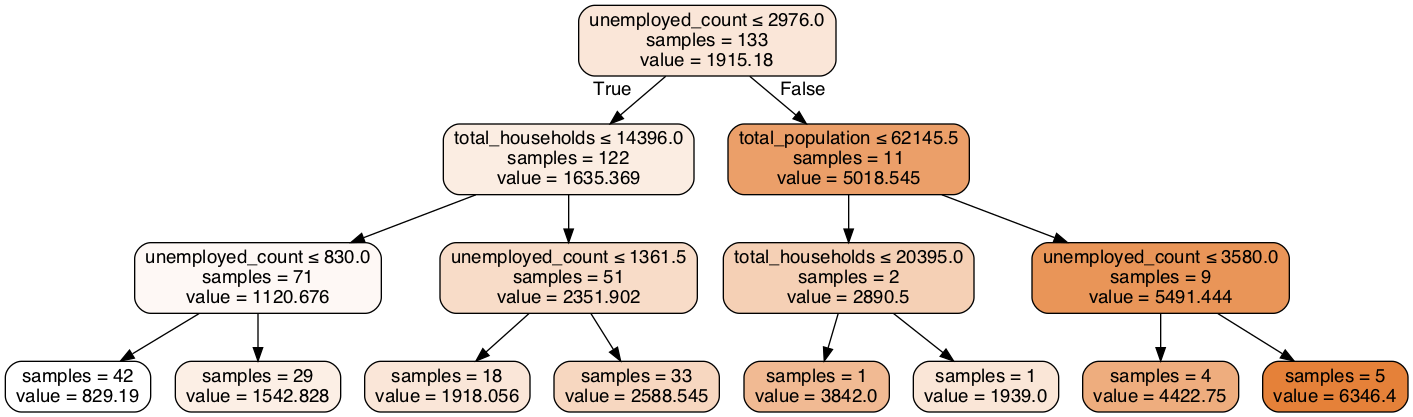

In [134]:
dt = DecisionTreeRegressor(max_depth=3) # just to keep it simple for visualization
dt.fit(X_train,Y_train)
thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values,  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False)
graph = pydotplus.graph_from_dot_data(thestring)  
img = Image(graph.create_png())  
display(img)

In [135]:
sociodemo_1819 = sociodemo_1819.dropna()
Y_C0_1819 = sociodemo_1819.loc[:,"Cluster 0"]
X_C0_1819 = sociodemo_1819.loc[:,"total_population":"avg_household_size"]
C0_pred_pcntg_difference = ((pred_df['predicted']-Y_C0_1819)/Y_C0_1819)*100
C0_actual_pcntg_difference = ((Y-Y_C0_1819)/Y_C0_1819)*100
NTA_pcnt_difference = pd.DataFrame(sociodemo_1920['NTACode']).join(pd.DataFrame(C0_pred_pcntg_difference)).\
                        rename(columns={0:'Predicted % difference'}).\
                        join(pd.DataFrame(C0_actual_pcntg_difference)).\
                        rename(columns = {'Cluster 0':'Actual % difference'})
NTA_pcnt_difference.head()

NTACode  Predicted % difference  Actual % difference
0    BK88               -8.176766            -8.176766
1    QN51                1.919386             1.919386
2    QN27              -12.362911           -12.362911
3    QN07              -23.208880           -23.208880
4    MN06              -30.553561             3.685092

In [136]:
test_NTAs = NTA_pcnt_difference.loc[NTA_pcnt_difference.index.isin(X_test.index)]
NTA_pcnt_difference_C0 = NYC.merge(NTA_pcnt_difference, on='NTACode')

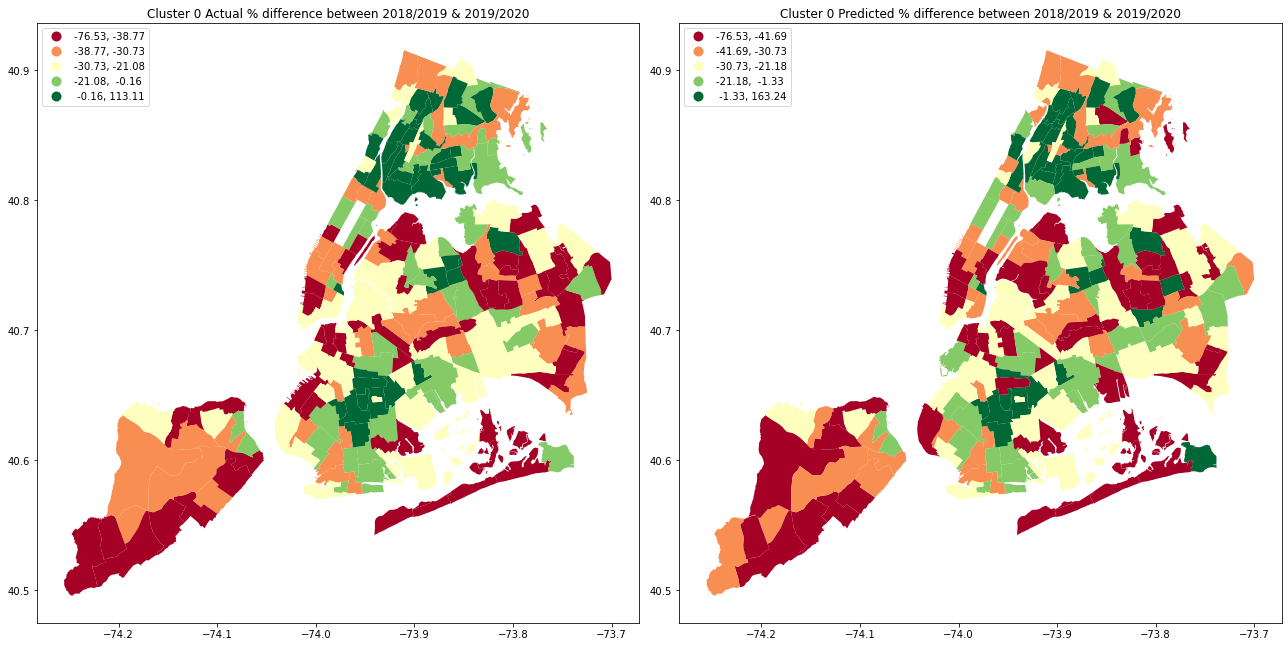

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(18,20))

NTA_pcnt_difference_C0.plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},cmap = 'RdYlGn')

NTA_pcnt_difference_C0.plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',
                              legend_kwds={'loc':'upper left'},cmap='RdYlGn')


ax[1].set_title("Cluster 0 Predicted % difference between 2018/2019 & 2019/2020")
ax[0].set_title("Cluster 0 Actual % difference between 2018/2019 & 2019/2020")
fig.tight_layout()

/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


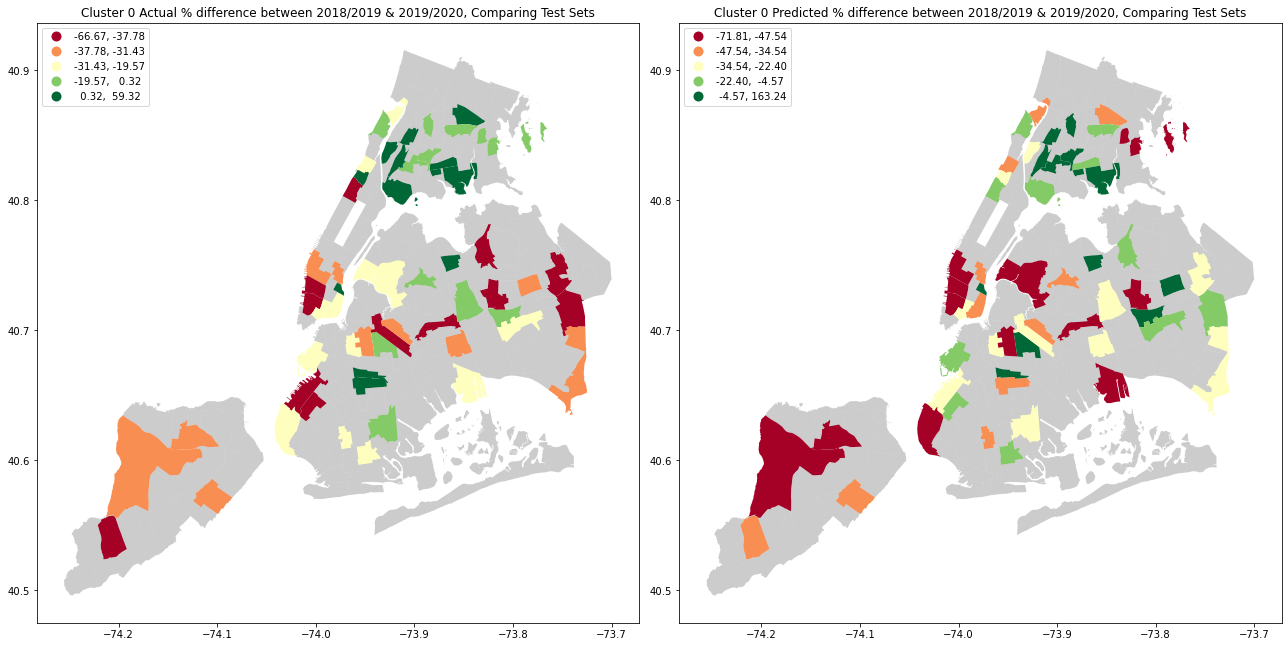

In [138]:
fig, ax = plt.subplots(1, 2, figsize=(18,20))

NTA_pcnt_difference_C0.loc[NTA_pcnt_difference_C0['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},cmap='RdYlGn')

NTA_pcnt_difference_C0.loc[~NTA_pcnt_difference_C0['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},color='Grey',alpha=0.4)

NTA_pcnt_difference_C0.loc[NTA_pcnt_difference_C0['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',
                              legend_kwds={'loc':'upper left'},cmap='RdYlGn')

NTA_pcnt_difference_C0.loc[~NTA_pcnt_difference_C0['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',legend_kwds={'loc':'upper left'},color='Grey',alpha=0.4)

ax[1].set_title("Cluster 0 Predicted % difference between 2018/2019 & 2019/2020, Comparing Test Sets")
ax[0].set_title("Cluster 0 Actual % difference between 2018/2019 & 2019/2020, Comparing Test Sets")
fig.tight_layout()

## 4.3 Cluster 1 Comparing (2018-2019) to (2019-20)

In [166]:
sociodemo_1920 = sociodemo_1920.dropna()
Y = sociodemo_1920.loc[:,"Cluster 1"]
X = sociodemo_1920.loc[:,"total_population":"avg_household_size"]

# Split data into 70% train, 30% test
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.3, random_state=990)
param_grid = {'max_depth':range(1,20)}
DTR = DecisionTreeRegressor(random_state=999)
gs = GridSearchCV(DTR,param_grid=param_grid,scoring='explained_variance').fit(X_train,Y_train)
pred=gs.predict(X_test)
print(gs.best_params_)
print(explained_variance_score(np.array(Y_test),pred)) 

{'max_depth': 2}
0.5088762302032185


In [167]:
pred_df = X_test.reset_index().join(pd.DataFrame(pred)).rename(columns={0:'predicted'}).set_index('index').\
            append(X_train.join(pd.DataFrame(Y_train)).rename(columns={'Cluster 1':'predicted'})).sort_index()

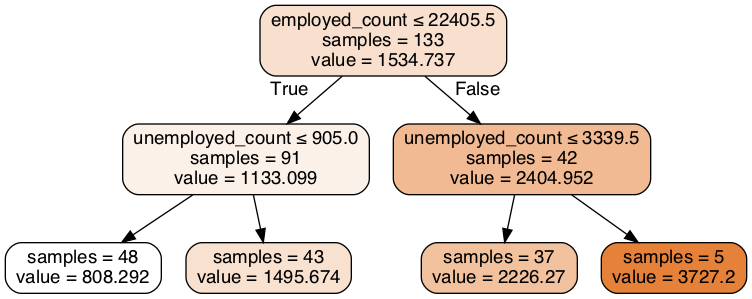

In [168]:
dt = DecisionTreeRegressor(max_depth=2) # just to keep it simple for visualization
dt.fit(X_train,Y_train)
thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values,  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False)
graph = pydotplus.graph_from_dot_data(thestring)  
img = Image(graph.create_png())  
display(img)

In [169]:
sociodemo_1819 = sociodemo_1819.dropna()
Y_C1_1819 = sociodemo_1819.loc[:,"Cluster 1"]
X_C1_1819 = sociodemo_1819.loc[:,"total_population":"avg_household_size"]

In [170]:
C1_pred_pcntg_difference = ((pred_df['predicted']-Y_C1_1819)/Y_C1_1819)*100
C1_actual_pcntg_difference = ((Y-Y_C1_1819)/Y_C1_1819)*100
NTA_pcnt_difference = pd.DataFrame(sociodemo_1920['NTACode']).join(pd.DataFrame(C1_pred_pcntg_difference)).\
                        rename(columns={0:'Predicted % difference'}).\
                        join(pd.DataFrame(C1_actual_pcntg_difference)).\
                        rename(columns = {'Cluster 1':'Actual % difference'})
NTA_pcnt_difference.head()

NTACode  Predicted % difference  Actual % difference
0    BK88              -63.355227           -63.355227
1    QN51              -66.155321           -66.155321
2    QN27              -14.375883           -64.830508
3    QN07              -55.775578           -55.775578
4    MN06              -46.693878           -46.693878

In [171]:
test_NTAs = NTA_pcnt_difference.loc[NTA_pcnt_difference.index.isin(X_test.index)]
NTA_pcnt_difference_C1 = NYC.merge(NTA_pcnt_difference, on='NTACode')

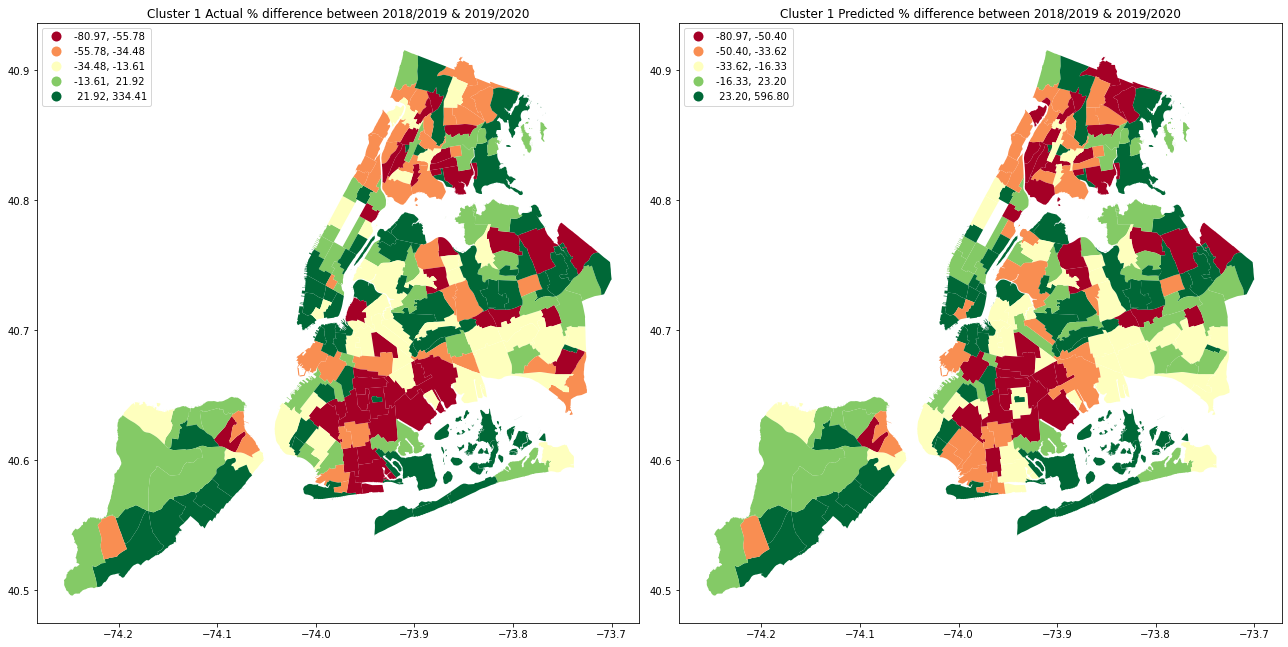

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(18,20))

NTA_pcnt_difference_C1.plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},cmap = 'RdYlGn')

NTA_pcnt_difference_C1.plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',
                              legend_kwds={'loc':'upper left'},cmap='RdYlGn')


ax[1].set_title("Cluster 1 Predicted % difference between 2018/2019 & 2019/2020")
ax[0].set_title("Cluster 1 Actual % difference between 2018/2019 & 2019/2020")
fig.tight_layout()

/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


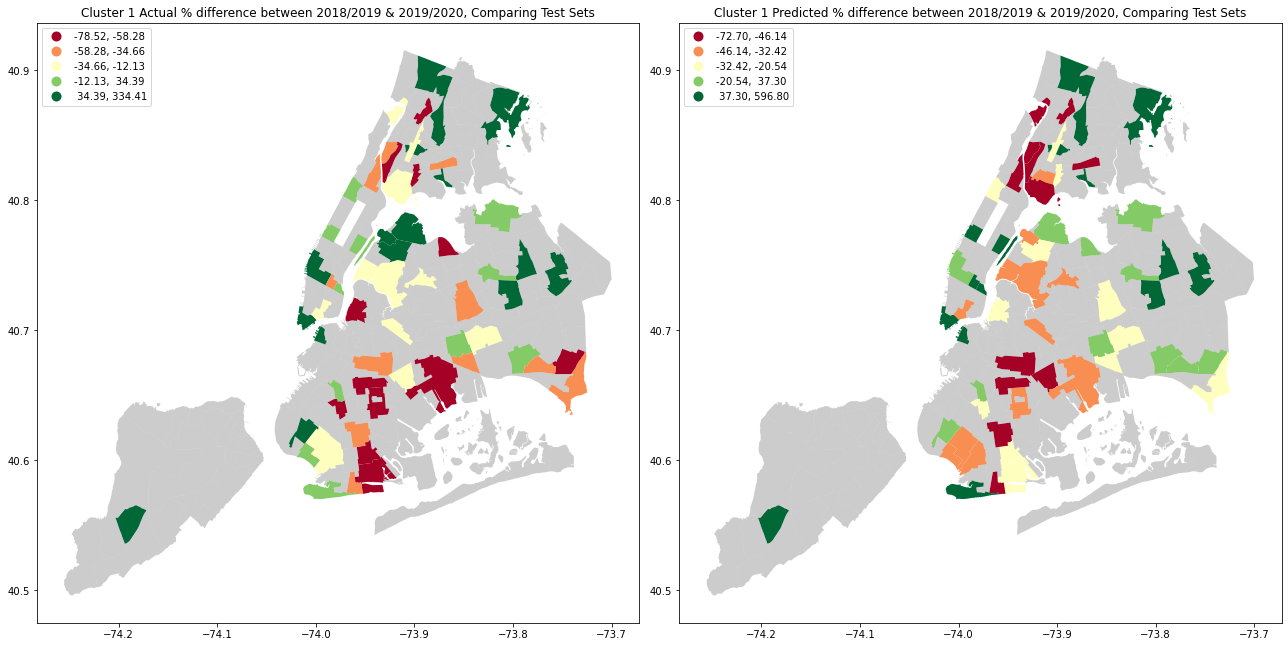

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(18,20))

NTA_pcnt_difference_C1.loc[NTA_pcnt_difference_C1['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},cmap='RdYlGn')

NTA_pcnt_difference_C1.loc[~NTA_pcnt_difference_C1['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},color='Grey',alpha=0.4)

NTA_pcnt_difference_C1.loc[NTA_pcnt_difference_C1['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',
                              legend_kwds={'loc':'upper left'},cmap='RdYlGn')

NTA_pcnt_difference_C1.loc[~NTA_pcnt_difference_C1['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',legend_kwds={'loc':'upper left'},color='Grey',alpha=0.4)

ax[1].set_title("Cluster 1 Predicted % difference between 2018/2019 & 2019/2020, Comparing Test Sets")
ax[0].set_title("Cluster 1 Actual % difference between 2018/2019 & 2019/2020, Comparing Test Sets")
fig.tight_layout()

## 4.4 Cluster 0 Comparing Pre-lockdown measures to during lockdown

In [174]:
joined_complaints1920['Created Date'] = pd.to_datetime(joined_complaints1920['Created Date'], format='%Y-%m-%d')
Cluster_Count_pre_lkdn = joined_complaints1920.loc[joined_complaints1920['Created Date']<'2020-03-01'].\
                            groupby(['NTACode','Cluster']).size().unstack(fill_value=0).reset_index()
Cluster_Count_during_lkdn = joined_complaints1920.loc[joined_complaints1920['Created Date']>='2020-03-01'].\
                            groupby(['NTACode','Cluster']).size().unstack(fill_value=0).reset_index()

In [175]:
sociodemo_pre_lkdn = sociodemo.merge(Cluster_Count_pre_lkdn,on='NTACode').rename(columns = {0:'Cluster 0',1:'Cluster 1'})
sociodemo_during_lkdn = sociodemo.merge(Cluster_Count_during_lkdn,on='NTACode').rename(columns = {0:'Cluster 0',1:'Cluster 1'})

In [176]:
sociodemo_during_lkdn=sociodemo_during_lkdn.dropna()

In [177]:
Y = sociodemo_during_lkdn.loc[:,"Cluster 0"]
X = sociodemo_during_lkdn.loc[:,"total_population":"avg_household_size"]

# Split data into 70% train, 30% test
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.3, random_state=666)
param_grid = {'max_depth':range(1,20)}
DTR = DecisionTreeRegressor(random_state=999)
gs = GridSearchCV(DTR,param_grid=param_grid,scoring='explained_variance').fit(X_train,Y_train)
pred=gs.predict(X_test)
print(gs.best_params_)
print(explained_variance_score(np.array(Y_test),pred)) 
#we can use a different scoring method, i didn't dig into the documentation that much

{'max_depth': 4}
0.6207560506751073


In [178]:
pred_df = X_test.reset_index().join(pd.DataFrame(pred)).rename(columns={0:'predicted'}).set_index('index').\
            append(X_train.join(pd.DataFrame(Y_train)).rename(columns={'Cluster 0':'predicted'})).sort_index()

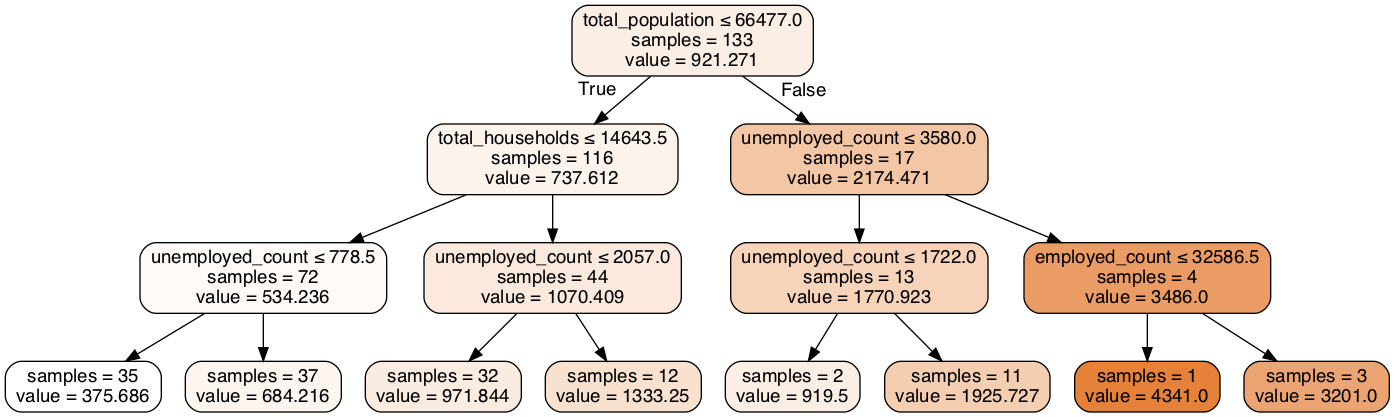

In [181]:
dt = DecisionTreeRegressor(max_depth=3) # just to keep it simple for visualization
dt.fit(X_train,Y_train)
thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values,  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False)
graph = pydotplus.graph_from_dot_data(thestring)  
img = Image(graph.create_png())  
display(img)

In [182]:
Y_C0_pre_lkdn = sociodemo_pre_lkdn.loc[:,"Cluster 0"]
X_C0_pre_lkdn = sociodemo_pre_lkdn.loc[:,"total_population":"avg_household_size"]

In [183]:
C0_pred_pcntg_difference = ((pred_df['predicted']-Y_C0_pre_lkdn)/Y_C0_pre_lkdn)*100
C0_actual_pcntg_difference = ((Y-Y_C0_pre_lkdn)/Y_C0_pre_lkdn)*100
NTA_pcnt_difference = pd.DataFrame(sociodemo_during_lkdn['NTACode']).join(pd.DataFrame(C0_pred_pcntg_difference)).\
                        rename(columns={0:'Predicted % difference'}).\
                        join(pd.DataFrame(C0_actual_pcntg_difference)).\
                        rename(columns = {'Cluster 0':'Actual % difference'})
NTA_pcnt_difference.head()

NTACode  Predicted % difference  Actual % difference
0    BK88              -34.136986            -9.863014
1    QN51              -24.101108           -27.737226
2    QN27              -25.248509           -25.248509
3    QN07               72.926727           -24.249423
4    MN06               19.893428            19.893428

In [184]:
test_NTAs = NTA_pcnt_difference.loc[NTA_pcnt_difference.index.isin(X_test.index)]
NTA_pcnt_difference_C0_1920 = NYC.merge(NTA_pcnt_difference, on='NTACode')

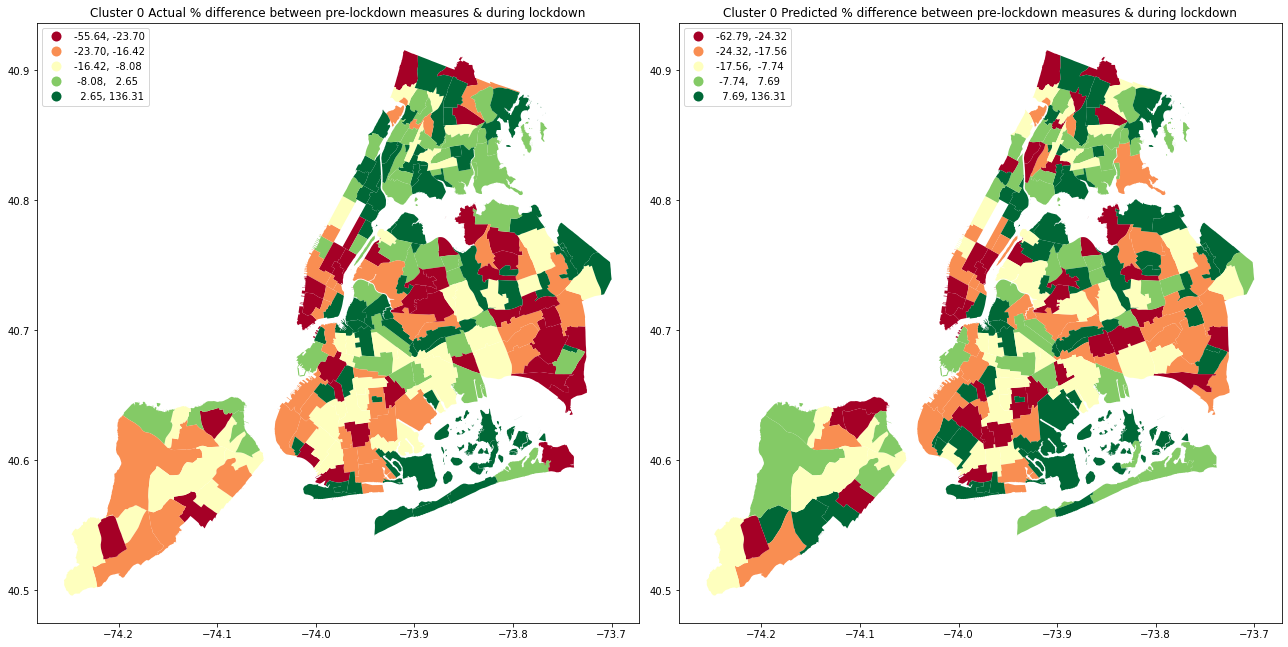

In [185]:
fig, ax = plt.subplots(1, 2, figsize=(18,20))

NTA_pcnt_difference_C0_1920.plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},cmap = 'RdYlGn')

NTA_pcnt_difference_C0_1920.plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',
                              legend_kwds={'loc':'upper left'},cmap='RdYlGn')


ax[1].set_title("Cluster 0 Predicted % difference between pre-lockdown measures & during lockdown")
ax[0].set_title("Cluster 0 Actual % difference between pre-lockdown measures & during lockdown")
fig.tight_layout()

/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


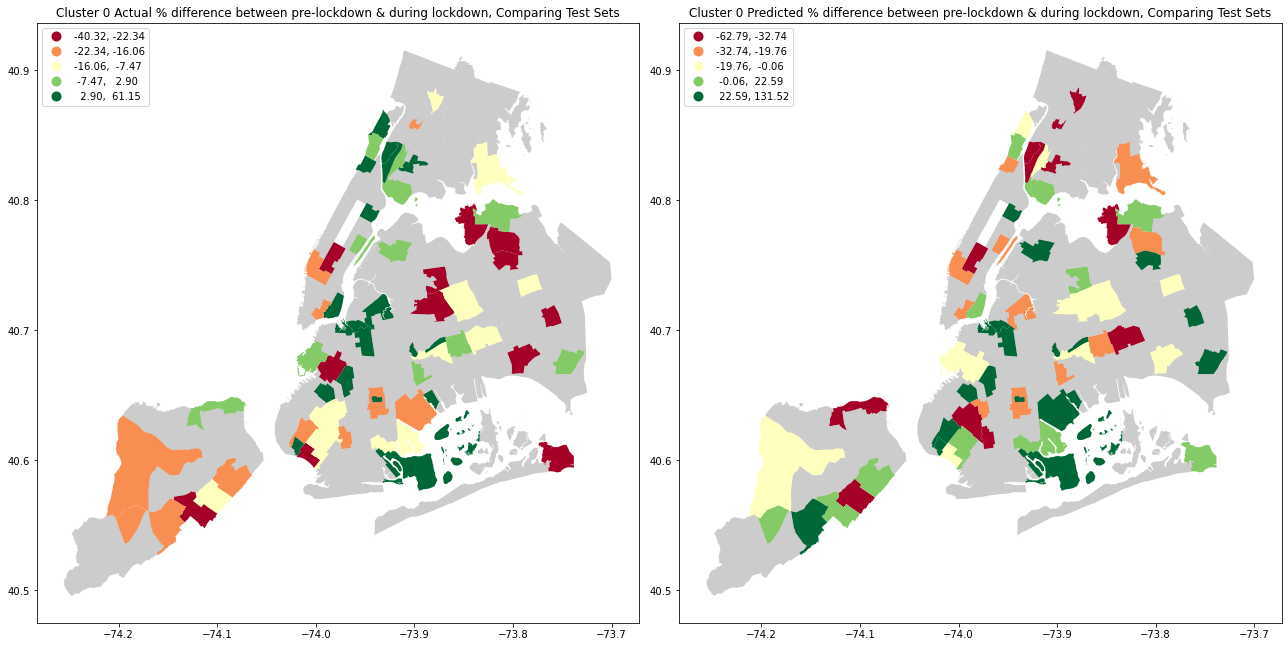

In [186]:
fig, ax = plt.subplots(1, 2, figsize=(18,20))

NTA_pcnt_difference_C0_1920.loc[NTA_pcnt_difference_C0_1920['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},cmap='RdYlGn')

NTA_pcnt_difference_C0_1920.loc[~NTA_pcnt_difference_C0_1920['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},color='Grey',alpha=0.4)

NTA_pcnt_difference_C0_1920.loc[NTA_pcnt_difference_C0_1920['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',
                              legend_kwds={'loc':'upper left'},cmap='RdYlGn')

NTA_pcnt_difference_C0_1920.loc[~NTA_pcnt_difference_C0_1920['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',legend_kwds={'loc':'upper left'},color='Grey',alpha=0.4)

ax[1].set_title("Cluster 0 Predicted % difference between pre-lockdown & during lockdown, Comparing Test Sets")
ax[0].set_title("Cluster 0 Actual % difference between pre-lockdown & during lockdown, Comparing Test Sets")
fig.tight_layout()

## 4.5 Cluster 1 Comparing Pre-lockdown measures to during lockdown

In [205]:
Y = sociodemo_during_lkdn.loc[:,"Cluster 1"]
X = sociodemo_during_lkdn.loc[:,"total_population":"avg_household_size"]

# Split data into 70% train, 30% test
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.3, random_state=455)
param_grid = {'max_depth':range(1,20)}
DTR = DecisionTreeRegressor(random_state=999)
gs = GridSearchCV(DTR,param_grid=param_grid,scoring='explained_variance').fit(X_train,Y_train)
pred=gs.predict(X_test)
print(gs.best_params_)
print(explained_variance_score(np.array(Y_test),pred)) 
#we can use a different scoring method, i didn't dig into the documentation that much

{'max_depth': 2}
0.44304692115475963


In [206]:
pred_df = X_test.reset_index().join(pd.DataFrame(pred)).rename(columns={0:'predicted'}).set_index('index').\
            append(X_train.join(pd.DataFrame(Y_train)).rename(columns={'Cluster 1':'predicted'})).sort_index()

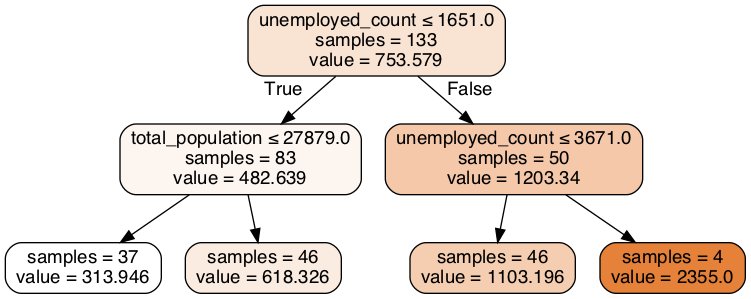

In [207]:
dt = DecisionTreeRegressor(max_depth=2) # just to keep it simple for visualization
dt.fit(X_train,Y_train)
thestring = tree.export_graphviz(dt, out_file=None,  
                         feature_names=X_train.columns.values,  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False)
graph = pydotplus.graph_from_dot_data(thestring)  
img = Image(graph.create_png())  
display(img)

In [208]:
Y_C1_pre_lkdn = sociodemo_pre_lkdn.loc[:,"Cluster 1"]
X_C1_pre_lkdn = sociodemo_pre_lkdn.loc[:,"total_population":"avg_household_size"]

In [209]:
C1_pred_pcntg_difference = ((pred_df['predicted']-Y_C1_pre_lkdn)/Y_C1_pre_lkdn)*100
C1_actual_pcntg_difference = ((Y-Y_C1_pre_lkdn)/Y_C1_pre_lkdn)*100
NTA_pcnt_difference = pd.DataFrame(sociodemo_during_lkdn['NTACode']).join(pd.DataFrame(C1_pred_pcntg_difference)).\
                        rename(columns={0:'Predicted % difference'}).\
                        join(pd.DataFrame(C1_actual_pcntg_difference)).\
                        rename(columns = {'Cluster 1':'Actual % difference'})
test_NTAs = NTA_pcnt_difference.loc[NTA_pcnt_difference.index.isin(X_test.index)]
NTA_pcnt_difference_C1_1920 = NYC.merge(NTA_pcnt_difference, on='NTACode')

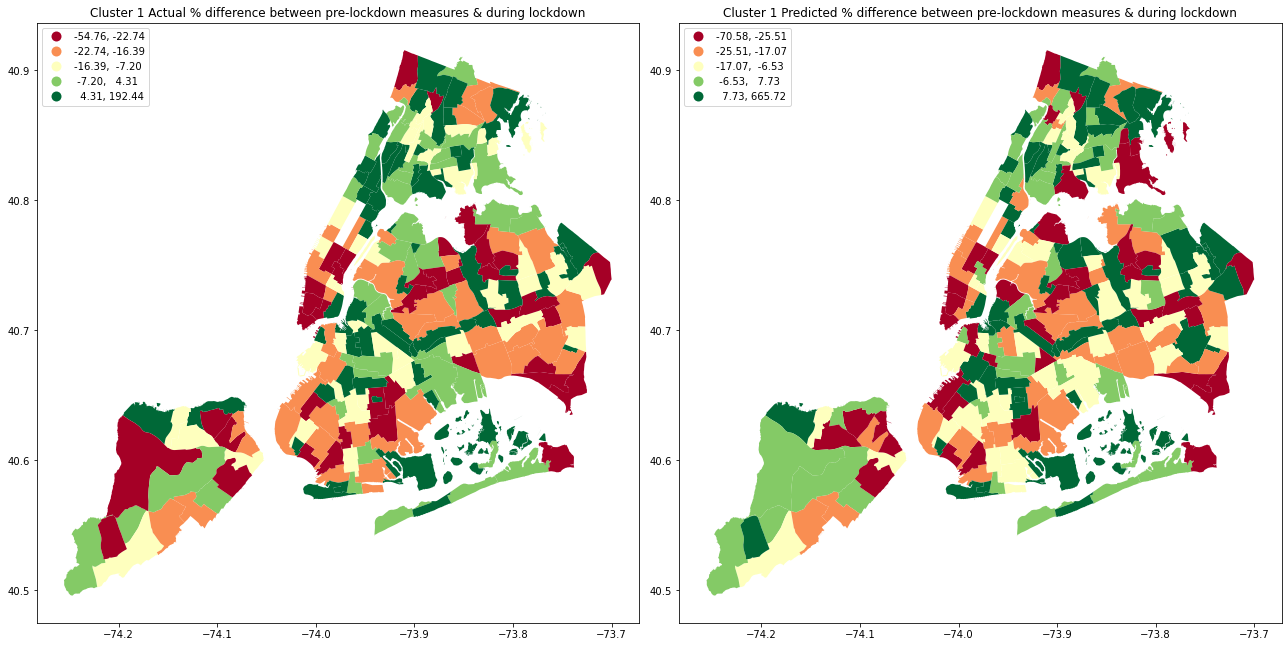

In [210]:
fig, ax = plt.subplots(1, 2, figsize=(18,20))

NTA_pcnt_difference_C1_1920.plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},cmap = 'RdYlGn')

NTA_pcnt_difference_C1_1920.plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',
                              legend_kwds={'loc':'upper left'},cmap='RdYlGn')


ax[1].set_title("Cluster 1 Predicted % difference between pre-lockdown measures & during lockdown")
ax[0].set_title("Cluster 1 Actual % difference between pre-lockdown measures & during lockdown")
fig.tight_layout()

/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/dinawagdy/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


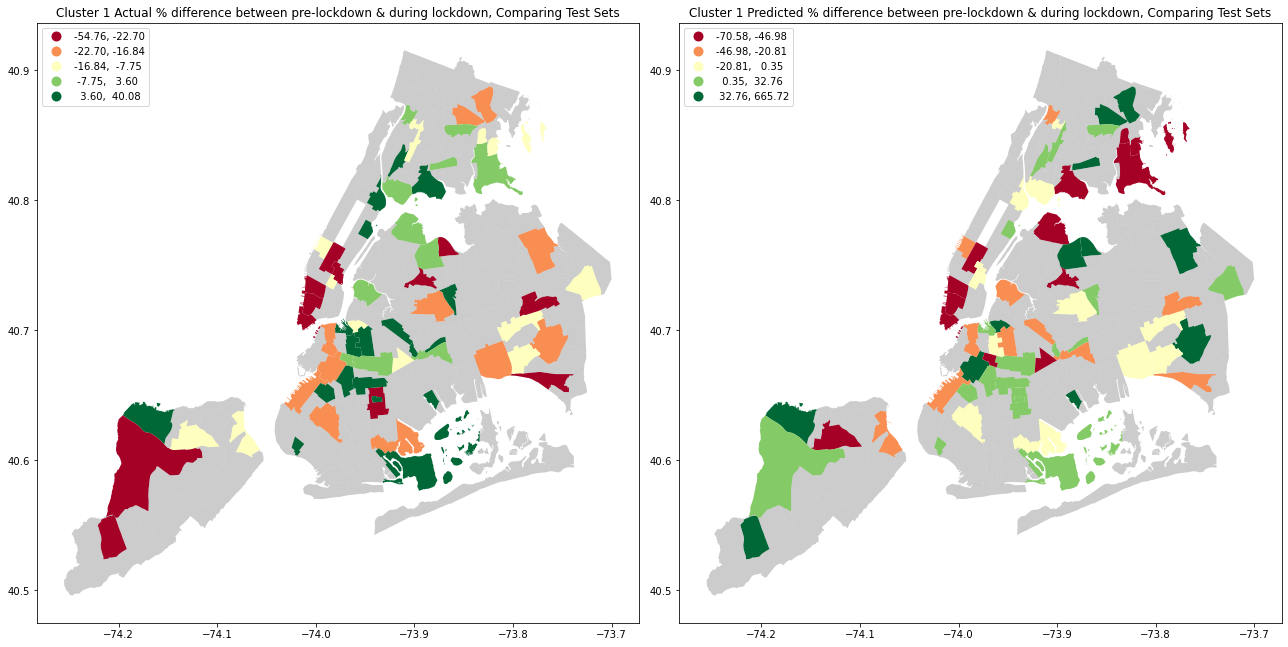

In [211]:
fig, ax = plt.subplots(1, 2, figsize=(18,20))

NTA_pcnt_difference_C1_1920.loc[NTA_pcnt_difference_C1_1920['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},cmap='RdYlGn')

NTA_pcnt_difference_C1_1920.loc[~NTA_pcnt_difference_C1_1920['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Actual % difference', ax=ax[0], scheme = 'quantiles', legend=True,
                         label='Actual % difference',legend_kwds={'loc':'upper left'},color='Grey',alpha=0.4)

NTA_pcnt_difference_C1_1920.loc[NTA_pcnt_difference_C1_1920['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',
                              legend_kwds={'loc':'upper left'},cmap='RdYlGn')

NTA_pcnt_difference_C1_1920.loc[~NTA_pcnt_difference_C1_1920['NTACode'].isin(test_NTAs['NTACode'])]\
                        .plot(column='Predicted % difference', ax=ax[1], scheme = 'quantiles',legend=True,
                         label='Predicted % difference',legend_kwds={'loc':'upper left'},color='Grey',alpha=0.4)

ax[1].set_title("Cluster 1 Predicted % difference between pre-lockdown & during lockdown, Comparing Test Sets")
ax[0].set_title("Cluster 1 Actual % difference between pre-lockdown & during lockdown, Comparing Test Sets")
fig.tight_layout()